# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# importing our custom python file containing the code related to the model creation
import model

## Create Train and Test Dataloaders

In [ ]:
def create_dataloaders(cuda_batch_size = 128, cpu_batch_size = 64):
  '''
  Creates train and test data loaders by applying transformations

  :param cuda_batch_size: batch size for cuda
  :param cpu_batch_size: batch size for cpu, if cuda is not available
  '''
  # Train Phase transformations
  train_transforms = transforms.Compose([
                                      transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(degrees=7, shear=10, translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.40, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) 
                                       ])

  # Test Phase transformations
  test_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])



  train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
  test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

  SEED = 1

  # CUDA?
  cuda = torch.cuda.is_available()
  print("CUDA Available?", cuda)

  # For reproducibility
  torch.manual_seed(SEED)

  if cuda:
      torch.cuda.manual_seed(SEED)

  # dataloader arguments
  dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

  # train dataloader
  train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

  # test dataloader
  test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

  return train_loader, test_loader



In [ ]:
# Let's now actually create the data loaders
train_loader, test_loader = create_dataloaders()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

CUDA Available? True


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# The Model and Params


In [ ]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

dropout_rate = 0.05
no_of_groups_for_GN, no_of_groups_for_LN = 4, 1

# For next set of assignmnets we would move this code onto createmodel python file
# and would save the weights
def create_BN_GN_LN_models(device, dropout_rate, no_of_groups_for_GN, no_of_groups_for_LN):
  '''
  Creates models by referring the model file and returns

  :param device: cuda (gpu) or cpu
  :param dropout_rate: dropout rate
  :param no_of_groups_for_GN: number of groups for group normalization
  :param no_of_groups_for_LN: number of groups for layer normalization, typically 1
  '''
  model_BN = model.Net(norm_type = 'BN', dropout_value = dropout_rate).to(device)
  model_GN = model.Net(norm_type = 'GN', dropout_value = dropout_rate).to(device)
  model_LN = model.Net(norm_type = 'LN', dropout_value = dropout_rate).to(device)
  return model_BN, model_GN, model_LN

model_BN, model_GN, model_LN = create_BN_GN_LN_models(device, dropout_rate, no_of_groups_for_GN, no_of_groups_for_LN)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print('Batch Normalization Model Parameters: ')
summary(model_BN, input_size=(1, 28, 28))

Batch Normalization Model Parameters: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
      BatchNorm2d-13           [-1, 16, 10, 10]              32


In [ ]:
print('Group Normalization Model Parameters: ')
summary(model_GN, input_size=(1, 28, 28))

Group Normalization Model Parameters: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32


In [ ]:
print('Layer Normalization Model Parameters: ')
summary(model_LN, input_size=(1, 28, 28))

Layer Normalization Model Parameters: 
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
         GroupNorm-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 16, 10, 10]           1,152
             ReLU-12           [-1, 16, 10, 10]               0
        GroupNorm-13           [-1, 16, 10, 10]              32


# Training and Testing

In [ ]:
from tqdm import tqdm
from torch.optim.lr_scheduler import LambdaLR, StepLR, OneCycleLR
import numpy as np
import math
import pandas as pd
import pickle

model_metrics = {}
epochs = 20


def train(model, device, train_loader, optimizer, 
          epoch,lambda_l1,scheduler,model_key,
          train_accuracy_key,train_loss_key):
  '''
    This method is responsible for training the model.
    We are building the dictionary like the following - 
    {
      'Model Key': {
        'training_accuracy': [],
        'training_loss': [],
        'testing_accuracy': [],
        'testing_loss': []
      }
    }

    Model keys are kept in the following form - 
    Model_<normalization type>_<l1 factor>_<l2 factor>

    Normalization type can be BN, LN or GN. BN is used for batch
    normalization, LN for layer normalization, and GN for
    group normalization.

    :param model: model
    :param device: device, cuda (gpu) or cpu
    :param train_loader: train loader
    :param optimizer:  optimizer, adam, sgd, for example
    :param epoch: epoch, number of times we are seeing entire training data
    :param lambda_l1: l1 regularizon parameter
    :param scheduler: scheduler
    :param model_key: model key to identify model specific metrics
    :param train_accuracy_key: train accuracy key for that model
    :param train_loss_key: train loss key for that model
  '''

  train_loss_local, train_accuracy_local = [], []
  

  
  if model_key not in model_metrics.keys():
    model_metrics[model_key] = {}
  
  if train_accuracy_key not in model_metrics[model_key].keys():
    model_metrics[model_key][train_accuracy_key] = []
  
  if train_loss_key not in model_metrics[model_key].keys():
    model_metrics[model_key][train_loss_key] = []
  
  correct, processed = 0, 0

  model.train()
  pbar = tqdm(train_loader)
  enumeration_count = 0
  
  for batch_idx, (data, target) in enumerate(pbar):
    enumeration_count += 1
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    y_pred = model(data)
    loss = F.nll_loss(y_pred, target)
    
    #L1 Regularization
    
    if lambda_l1 > 0:
      l1 = 0
      for p in model.parameters():
        l1 = l1 + p.abs().sum()
      loss = loss + lambda_l1*l1
    

    train_loss_local.append(loss.data.cpu().numpy().item())

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True) 
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_accuracy_local.append(100*correct/processed)

  model_metrics[model_key][train_loss_key].append(loss.item())
  model_metrics[model_key][train_accuracy_key].append(round(100*correct/processed, 2))

def test(model, device, test_loader,model_key,
          test_accuracy_key,test_loss_key):
  '''
  This method is responsible for testing the model.
  Alongwith that we are keeping track of misclassified 10 images per model.

  Like earlier we showed in training,
  we are maintaining the dictionary in the following form - 
  
    We are building the dictionary like the following - 
    {
      'Model Key': {
        'training_accuracy': [],
        'training_loss': [],
        'testing_accuracy': [],
        'testing_loss': []
      }
    }

    Model keys are kept in the following form - 
    Model_<normalization type>_<l1 factor>_<l2 factor>

    Normalization type can be BN, LN or GN. BN is used for batch
    normalization, LN for layer normalization, and GN for
    group normalization.

    :param model: model
    :param device: device, cuda (gpu) or cpu
    :param test_loader: test loader
    :param model_key: model key to identify model specific metrics
    :param test_accuracy_key: test accuracy key for that model
    :param test_loss_key: test loss key for that model
  '''
  wrong_images, wrong_label, correct_label = [], [], []
  current_misprediction_count = 0

  if model_key not in model_metrics.keys():
    model_metrics[model_key] = {}
  
  if test_accuracy_key not in model_metrics[model_key].keys():
    model_metrics[model_key][test_accuracy_key] = []
  
  if test_loss_key not in model_metrics[model_key].keys():
    model_metrics[model_key][test_loss_key] = []

  model.eval()
  test_loss, correct = 0, 0
  correct = 0
  with torch.no_grad():
      for data, target in test_loader:
          data, target = data.to(device), target.to(device)
          output = model(data)
          test_loss += F.nll_loss(output, target, reduction='sum').item()
          pred = output.argmax(dim=1, keepdim=True)
          correct += pred.eq(target.view_as(pred)).sum().item()

          wrong_pred = (pred.eq(target.view_as(pred)) == False)

          if current_misprediction_count < 10:
            wrong_images.append(data[wrong_pred])
            wrong_label.append(pred[wrong_pred])
            correct_label.append(target.view_as(pred)[wrong_pred])  
            wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label))) 
            current_misprediction_count += 1

  test_loss /= len(test_loader.dataset)
  model_metrics[model_key][test_loss_key].append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
  model_metrics[model_key][test_accuracy_key].append(100. * correct / len(test_loader.dataset))
  return wrong_predictions

def get_models():
  '''
  This method maintains the dictionary as per model key.
  Per model key, we have the model, norm type, l1 factor and l2 factor, as dictionary values.
  '''
  dict_models = {}
  dict_models['Model_BN_0_0'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': 0, 'L2_Factor': 0}
  dict_models['Model_BN_0_001'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': 0, 'L2_Factor': .001}
  dict_models['Model_BN_0_002'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': 0, 'L2_Factor': .002}

  dict_models['Model_BN_001_0'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': .001, 'L2_Factor': 0}
  dict_models['Model_BN_001_001'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': .001, 'L2_Factor': .001}
  dict_models['Model_BN_001_002'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': .001, 'L2_Factor': .002}

  dict_models['Model_BN_002_0'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': .002, 'L2_Factor': 0}
  dict_models['Model_BN_002_001'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': .002, 'L2_Factor': .001}
  dict_models['Model_BN_002_002'] = {'Model': model_BN,'Norm_type': 'BN','L1_Factor': .002, 'L2_Factor': .002}

  dict_models['Model_LN_0_0'] = {'Model': model_LN,'Norm_type': 'LN','L1_Factor': 0, 'L2_Factor': 0}
  dict_models['Model_LN_0_001'] = {'Model': model_LN,'Norm_type': 'LN','L1_Factor': 0, 'L2_Factor': .001}
  dict_models['Model_LN_0_002'] = {'Model': model_LN,'Norm_type': 'LN','L1_Factor': 0, 'L2_Factor': .002}


  dict_models['Model_GN_0_0'] = {'Model': model_GN,'Norm_type': 'GN','L1_Factor': 0, 'L2_Factor': 0}
  dict_models['Model_GN_0_001'] = {'Model': model_GN,'Norm_type': 'GN','L1_Factor': 0, 'L2_Factor': .001}
  dict_models['Model_GN_0_002'] = {'Model': model_GN,'Norm_type': 'GN','L1_Factor': 0, 'L2_Factor': .002}

  return dict_models

def get_l2_factors():
  '''
  This method is returning the set of l2 factors we are using.
  '''
  return [0, .001, .002]

def get_l2_factor_model_name_extension(l2factor, l1factor, norm):
  '''
  This method is an utility method, it forms the model key
  from the factors and norm, and returns it.

  :param l2factor: l2 factor
  :param l1factor: l1 factor
  :param norm: normalization type, can be BN, LN or GN
  '''
  if l1factor == .001:
    l1factor_local = '001'
  elif l1factor == .002:
    l1factor_local = '002'
  else:
    l1factor_local = '0'
  
  if l2factor == .001:
    l2factor_local = '001'
  elif l2factor == .002:
    l2factor_local = '002'
  else:
    l2factor_local = '0'
  
  return 'Model_' + norm + '_' + l1factor_local + '_' + l2factor_local
  


def experiments(device, model_key):
  '''
  This method is used for doing experiment per each model.
  It calls train and test method to calculate and note accuracies and losses.

  :param device: device, cuda (gpu) or cpu
  :param model_key: model key
  '''
    dict_models = get_models()
    weight_decays = get_l2_factors()
    wrong_predictions = {}

    #for m in dict_models.keys():
      #for wd in weight_decays:
    m = model_key
    model_key_local = get_l2_factor_model_name_extension(dict_models[m]['L2_Factor'], 
                                                          dict_models[m]['L1_Factor'], dict_models[m]['Norm_type'])
    
    

    optimizer = optim.SGD(dict_models[m]['Model'].parameters(), lr=0.015, momentum=0.7,weight_decay= dict_models[m]['L2_Factor'])
    scheduler = OneCycleLR(optimizer, max_lr=0.015,epochs=epochs,steps_per_epoch=len(train_loader))
    wrong_predictions[model_key_local] = []

    for epoch in range(1, epochs + 1):
      print(f'Epoch {epoch}:')
      train(dict_models[m]['Model'], device, train_loader, optimizer, 
          epoch,dict_models[m]['L1_Factor'],scheduler, model_key_local,
          'Train_Accuracy','Train_Loss')
      wrong_predictions[model_key_local].append(test(dict_models[m]['Model'], 
                                                                device, test_loader, model_key_local,
          'Test_Accuracy', 'Test_Loss'))
    
    df_metrics = pd.DataFrame(model_metrics[model_key_local])
    df_metrics.to_csv(model_key_local + '.csv', index=False)

    with open(model_key_local + '.pkl', 'wb') as f:
      pickle.dump(wrong_predictions, f)
    


    
     

#Experiment Results - 

In [ ]:
print('Train and Test stats for BN, with L1 factor 0, and L2 factor 0:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_0_0')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0, and L2 factor 0:
----------------------------------------------------------------
Epoch 1:


Loss=0.38140541315078735 Batch_id=937 Accuracy=73.01: 100%|██████████| 938/938 [01:35<00:00,  9.77it/s]



Test set: Average loss: 0.1256, Accuracy: 9669/10000 (96.69%)

Epoch 2:


Loss=0.06730850040912628 Batch_id=937 Accuracy=93.75: 100%|██████████| 938/938 [01:29<00:00, 10.49it/s]



Test set: Average loss: 0.0648, Accuracy: 9795/10000 (97.95%)

Epoch 3:


Loss=0.07624442130327225 Batch_id=937 Accuracy=95.43: 100%|██████████| 938/938 [01:31<00:00, 10.28it/s]



Test set: Average loss: 0.0443, Accuracy: 9864/10000 (98.64%)

Epoch 4:


Loss=0.29438453912734985 Batch_id=937 Accuracy=96.38: 100%|██████████| 938/938 [01:30<00:00, 10.32it/s]



Test set: Average loss: 0.0298, Accuracy: 9901/10000 (99.01%)

Epoch 5:


Loss=0.014290872029960155 Batch_id=937 Accuracy=96.76: 100%|██████████| 938/938 [01:32<00:00, 10.16it/s]



Test set: Average loss: 0.0386, Accuracy: 9870/10000 (98.70%)

Epoch 6:


Loss=0.16280275583267212 Batch_id=937 Accuracy=97.02: 100%|██████████| 938/938 [01:31<00:00, 10.20it/s]



Test set: Average loss: 0.0351, Accuracy: 9887/10000 (98.87%)

Epoch 7:


Loss=0.02143159508705139 Batch_id=937 Accuracy=97.22: 100%|██████████| 938/938 [01:27<00:00, 10.67it/s]



Test set: Average loss: 0.0270, Accuracy: 9913/10000 (99.13%)

Epoch 8:


Loss=0.17667284607887268 Batch_id=937 Accuracy=97.33: 100%|██████████| 938/938 [01:29<00:00, 10.52it/s]



Test set: Average loss: 0.0262, Accuracy: 9919/10000 (99.19%)

Epoch 9:


Loss=0.13682237267494202 Batch_id=937 Accuracy=97.45: 100%|██████████| 938/938 [01:28<00:00, 10.58it/s]



Test set: Average loss: 0.0244, Accuracy: 9923/10000 (99.23%)

Epoch 10:


Loss=0.012277331203222275 Batch_id=937 Accuracy=97.74: 100%|██████████| 938/938 [01:28<00:00, 10.54it/s]



Test set: Average loss: 0.0244, Accuracy: 9929/10000 (99.29%)

Epoch 11:


Loss=0.16839590668678284 Batch_id=937 Accuracy=97.77: 100%|██████████| 938/938 [01:25<00:00, 10.91it/s]



Test set: Average loss: 0.0216, Accuracy: 9933/10000 (99.33%)

Epoch 12:


Loss=0.0690573900938034 Batch_id=937 Accuracy=97.84: 100%|██████████| 938/938 [01:26<00:00, 10.89it/s]



Test set: Average loss: 0.0217, Accuracy: 9936/10000 (99.36%)

Epoch 13:


Loss=0.1935119926929474 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [01:28<00:00, 10.57it/s]



Test set: Average loss: 0.0197, Accuracy: 9935/10000 (99.35%)

Epoch 14:


Loss=0.20241709053516388 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [01:26<00:00, 10.82it/s]



Test set: Average loss: 0.0180, Accuracy: 9942/10000 (99.42%)

Epoch 15:


Loss=0.26267850399017334 Batch_id=937 Accuracy=97.97: 100%|██████████| 938/938 [01:26<00:00, 10.86it/s]



Test set: Average loss: 0.0175, Accuracy: 9942/10000 (99.42%)

Epoch 16:


Loss=0.14611446857452393 Batch_id=937 Accuracy=98.05: 100%|██████████| 938/938 [01:31<00:00, 10.28it/s]



Test set: Average loss: 0.0180, Accuracy: 9941/10000 (99.41%)

Epoch 17:


Loss=0.010591144673526287 Batch_id=937 Accuracy=98.21: 100%|██████████| 938/938 [01:26<00:00, 10.80it/s]



Test set: Average loss: 0.0171, Accuracy: 9948/10000 (99.48%)

Epoch 18:


Loss=0.015607846900820732 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [01:29<00:00, 10.46it/s]



Test set: Average loss: 0.0158, Accuracy: 9948/10000 (99.48%)

Epoch 19:


Loss=0.006705074105411768 Batch_id=937 Accuracy=98.36: 100%|██████████| 938/938 [01:26<00:00, 10.87it/s]



Test set: Average loss: 0.0169, Accuracy: 9945/10000 (99.45%)

Epoch 20:


Loss=0.004204779397696257 Batch_id=937 Accuracy=98.42: 100%|██████████| 938/938 [01:27<00:00, 10.76it/s]



Test set: Average loss: 0.0164, Accuracy: 9948/10000 (99.48%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0, and L2 factor 0.001:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_0_001')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0, and L2 factor 0.001:
----------------------------------------------------------------
Epoch 1:


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.49202385544776917 Batch_id=468 Accuracy=63.45: 100%|██████████| 469/469 [00:34<00:00, 13.48it/s]



Test set: Average loss: 0.2637, Accuracy: 9499/10000 (94.99%)

Epoch 2:


Loss=0.27910783886909485 Batch_id=468 Accuracy=91.79: 100%|██████████| 469/469 [00:34<00:00, 13.46it/s]



Test set: Average loss: 0.0662, Accuracy: 9845/10000 (98.45%)

Epoch 3:


Loss=0.2833850383758545 Batch_id=468 Accuracy=95.03: 100%|██████████| 469/469 [00:34<00:00, 13.45it/s]



Test set: Average loss: 0.0418, Accuracy: 9886/10000 (98.86%)

Epoch 4:


Loss=0.12308276444673538 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.0408, Accuracy: 9868/10000 (98.68%)

Epoch 5:


Loss=0.06830643862485886 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:34<00:00, 13.43it/s]



Test set: Average loss: 0.0285, Accuracy: 9919/10000 (99.19%)

Epoch 6:


Loss=0.16469836235046387 Batch_id=468 Accuracy=97.10: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]



Test set: Average loss: 0.0358, Accuracy: 9882/10000 (98.82%)

Epoch 7:


Loss=0.06487025320529938 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:35<00:00, 13.11it/s]



Test set: Average loss: 0.0259, Accuracy: 9922/10000 (99.22%)

Epoch 8:


Loss=0.06728126108646393 Batch_id=468 Accuracy=97.46: 100%|██████████| 469/469 [00:35<00:00, 13.32it/s]



Test set: Average loss: 0.0287, Accuracy: 9906/10000 (99.06%)

Epoch 9:


Loss=0.04668973386287689 Batch_id=468 Accuracy=97.52: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]



Test set: Average loss: 0.0255, Accuracy: 9929/10000 (99.29%)

Epoch 10:


Loss=0.02658090554177761 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:35<00:00, 13.25it/s]



Test set: Average loss: 0.0251, Accuracy: 9923/10000 (99.23%)

Epoch 11:


Loss=0.04944537207484245 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:35<00:00, 13.32it/s]



Test set: Average loss: 0.0262, Accuracy: 9924/10000 (99.24%)

Epoch 12:


Loss=0.08205502480268478 Batch_id=468 Accuracy=97.78: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.0260, Accuracy: 9927/10000 (99.27%)

Epoch 13:


Loss=0.0927739068865776 Batch_id=468 Accuracy=97.93: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

Epoch 14:


Loss=0.14265035092830658 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:35<00:00, 13.21it/s]



Test set: Average loss: 0.0218, Accuracy: 9932/10000 (99.32%)

Epoch 15:


Loss=0.03880902752280235 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:35<00:00, 13.25it/s]



Test set: Average loss: 0.0200, Accuracy: 9939/10000 (99.39%)

Epoch 16:


Loss=0.035227399319410324 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:35<00:00, 13.16it/s]



Test set: Average loss: 0.0183, Accuracy: 9938/10000 (99.38%)

Epoch 17:


Loss=0.030972430482506752 Batch_id=468 Accuracy=98.29: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99.41%)

Epoch 18:


Loss=0.04370884224772453 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.0164, Accuracy: 9951/10000 (99.51%)

Epoch 19:


Loss=0.011540145613253117 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:35<00:00, 13.27it/s]



Test set: Average loss: 0.0165, Accuracy: 9951/10000 (99.51%)

Epoch 20:


Loss=0.028170542791485786 Batch_id=468 Accuracy=98.45: 100%|██████████| 469/469 [00:37<00:00, 12.65it/s]



Test set: Average loss: 0.0163, Accuracy: 9954/10000 (99.54%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0, and L2 factor 0.002:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_0_002')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0, and L2 factor 0.002:
----------------------------------------------------------------
Epoch 1:


Loss=0.010706108994781971 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:34<00:00, 13.61it/s]



Test set: Average loss: 0.0186, Accuracy: 9947/10000 (99.47%)

Epoch 2:


Loss=0.1344427466392517 Batch_id=468 Accuracy=98.26: 100%|██████████| 469/469 [00:34<00:00, 13.57it/s]



Test set: Average loss: 0.0213, Accuracy: 9939/10000 (99.39%)

Epoch 3:


Loss=0.09368637949228287 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:34<00:00, 13.57it/s]



Test set: Average loss: 0.0241, Accuracy: 9932/10000 (99.32%)

Epoch 4:


Loss=0.10524633526802063 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:34<00:00, 13.40it/s]



Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

Epoch 5:


Loss=0.0847248062491417 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:34<00:00, 13.48it/s]



Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

Epoch 6:


Loss=0.0781732052564621 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:36<00:00, 12.96it/s]



Test set: Average loss: 0.0254, Accuracy: 9922/10000 (99.22%)

Epoch 7:


Loss=0.03200029581785202 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:34<00:00, 13.42it/s]



Test set: Average loss: 0.0353, Accuracy: 9896/10000 (98.96%)

Epoch 8:


Loss=0.1356448233127594 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:34<00:00, 13.49it/s]



Test set: Average loss: 0.0359, Accuracy: 9896/10000 (98.96%)

Epoch 9:


Loss=0.09542613476514816 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:34<00:00, 13.53it/s]



Test set: Average loss: 0.0279, Accuracy: 9920/10000 (99.20%)

Epoch 10:


Loss=0.1686144471168518 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:34<00:00, 13.48it/s]



Test set: Average loss: 0.0284, Accuracy: 9917/10000 (99.17%)

Epoch 11:


Loss=0.1304865926504135 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:35<00:00, 13.40it/s]



Test set: Average loss: 0.0285, Accuracy: 9928/10000 (99.28%)

Epoch 12:


Loss=0.049120280891656876 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:34<00:00, 13.46it/s]



Test set: Average loss: 0.0259, Accuracy: 9921/10000 (99.21%)

Epoch 13:


Loss=0.066494420170784 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:35<00:00, 13.04it/s]



Test set: Average loss: 0.0309, Accuracy: 9927/10000 (99.27%)

Epoch 14:


Loss=0.03142600879073143 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:34<00:00, 13.51it/s]



Test set: Average loss: 0.0247, Accuracy: 9927/10000 (99.27%)

Epoch 15:


Loss=0.05041560158133507 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:34<00:00, 13.56it/s]



Test set: Average loss: 0.0222, Accuracy: 9934/10000 (99.34%)

Epoch 16:


Loss=0.13167612254619598 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:34<00:00, 13.58it/s]



Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

Epoch 17:


Loss=0.04836075007915497 Batch_id=468 Accuracy=98.38: 100%|██████████| 469/469 [00:34<00:00, 13.47it/s]



Test set: Average loss: 0.0213, Accuracy: 9942/10000 (99.42%)

Epoch 18:


Loss=0.06750877946615219 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:34<00:00, 13.55it/s]



Test set: Average loss: 0.0165, Accuracy: 9952/10000 (99.52%)

Epoch 19:


Loss=0.08697152137756348 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:34<00:00, 13.49it/s]



Test set: Average loss: 0.0163, Accuracy: 9957/10000 (99.57%)

Epoch 20:


Loss=0.01687847077846527 Batch_id=468 Accuracy=98.71: 100%|██████████| 469/469 [00:35<00:00, 13.14it/s]



Test set: Average loss: 0.0164, Accuracy: 9959/10000 (99.59%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0.001, and L2 factor 0:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_001_0')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0.001, and L2 factor 0:
----------------------------------------------------------------
Epoch 1:


Loss=0.48641911149024963 Batch_id=468 Accuracy=98.59: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0208, Accuracy: 9937/10000 (99.37%)

Epoch 2:


Loss=0.4028869867324829 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0282, Accuracy: 9916/10000 (99.16%)

Epoch 3:


Loss=0.3607528507709503 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:35<00:00, 13.22it/s]



Test set: Average loss: 0.0669, Accuracy: 9796/10000 (97.96%)

Epoch 4:


Loss=0.6234390139579773 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0668, Accuracy: 9819/10000 (98.19%)

Epoch 5:


Loss=0.36484259366989136 Batch_id=468 Accuracy=95.83: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.0541, Accuracy: 9846/10000 (98.46%)

Epoch 6:


Loss=0.32183635234832764 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0490, Accuracy: 9854/10000 (98.54%)

Epoch 7:


Loss=0.3322609066963196 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]



Test set: Average loss: 0.0689, Accuracy: 9794/10000 (97.94%)

Epoch 8:


Loss=0.3558628559112549 Batch_id=468 Accuracy=96.12: 100%|██████████| 469/469 [00:35<00:00, 13.15it/s]



Test set: Average loss: 0.0675, Accuracy: 9793/10000 (97.93%)

Epoch 9:


Loss=0.3821384310722351 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]



Test set: Average loss: 0.0524, Accuracy: 9845/10000 (98.45%)

Epoch 10:


Loss=0.3881092667579651 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0553, Accuracy: 9832/10000 (98.32%)

Epoch 11:


Loss=0.34117159247398376 Batch_id=468 Accuracy=96.39: 100%|██████████| 469/469 [00:35<00:00, 13.19it/s]



Test set: Average loss: 0.0420, Accuracy: 9856/10000 (98.56%)

Epoch 12:


Loss=0.34678271412849426 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:35<00:00, 13.29it/s]



Test set: Average loss: 0.0560, Accuracy: 9847/10000 (98.47%)

Epoch 13:


Loss=0.41172727942466736 Batch_id=468 Accuracy=96.52: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s]



Test set: Average loss: 0.0748, Accuracy: 9790/10000 (97.90%)

Epoch 14:


Loss=0.39864134788513184 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:35<00:00, 13.21it/s]



Test set: Average loss: 0.0402, Accuracy: 9880/10000 (98.80%)

Epoch 15:


Loss=0.4479457139968872 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]



Test set: Average loss: 0.0353, Accuracy: 9893/10000 (98.93%)

Epoch 16:


Loss=0.25345921516418457 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:35<00:00, 13.14it/s]



Test set: Average loss: 0.0350, Accuracy: 9903/10000 (99.03%)

Epoch 17:


Loss=0.34356653690338135 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0291, Accuracy: 9917/10000 (99.17%)

Epoch 18:


Loss=0.26378196477890015 Batch_id=468 Accuracy=97.60: 100%|██████████| 469/469 [00:36<00:00, 13.02it/s]



Test set: Average loss: 0.0255, Accuracy: 9922/10000 (99.22%)

Epoch 19:


Loss=0.2460157871246338 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]



Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

Epoch 20:


Loss=0.24666491150856018 Batch_id=468 Accuracy=98.19: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0189, Accuracy: 9941/10000 (99.41%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0.001, and L2 factor 0.001:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_001_001')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0.001, and L2 factor 0.001:
----------------------------------------------------------------
Epoch 1:


Loss=0.2717297077178955 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 0.0303, Accuracy: 9909/10000 (99.09%)

Epoch 2:


Loss=0.359923392534256 Batch_id=468 Accuracy=96.59: 100%|██████████| 469/469 [00:35<00:00, 13.15it/s]



Test set: Average loss: 0.0428, Accuracy: 9871/10000 (98.71%)

Epoch 3:


Loss=0.2950172424316406 Batch_id=468 Accuracy=96.11: 100%|██████████| 469/469 [00:35<00:00, 13.09it/s]



Test set: Average loss: 0.0572, Accuracy: 9836/10000 (98.36%)

Epoch 4:


Loss=0.3762875199317932 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]



Test set: Average loss: 0.0607, Accuracy: 9816/10000 (98.16%)

Epoch 5:


Loss=0.37133660912513733 Batch_id=468 Accuracy=95.92: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]



Test set: Average loss: 0.0908, Accuracy: 9722/10000 (97.22%)

Epoch 6:


Loss=0.444711297750473 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:37<00:00, 12.58it/s]



Test set: Average loss: 0.0980, Accuracy: 9723/10000 (97.23%)

Epoch 7:


Loss=0.37014055252075195 Batch_id=468 Accuracy=96.06: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]



Test set: Average loss: 0.1225, Accuracy: 9619/10000 (96.19%)

Epoch 8:


Loss=0.4738636910915375 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0539, Accuracy: 9831/10000 (98.31%)

Epoch 9:


Loss=0.3343018889427185 Batch_id=468 Accuracy=96.20: 100%|██████████| 469/469 [00:36<00:00, 13.01it/s]



Test set: Average loss: 0.0410, Accuracy: 9876/10000 (98.76%)

Epoch 10:


Loss=0.361125648021698 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]



Test set: Average loss: 0.0535, Accuracy: 9828/10000 (98.28%)

Epoch 11:


Loss=0.34873542189598083 Batch_id=468 Accuracy=96.19: 100%|██████████| 469/469 [00:36<00:00, 12.80it/s]



Test set: Average loss: 0.0451, Accuracy: 9853/10000 (98.53%)

Epoch 12:


Loss=0.3497968912124634 Batch_id=468 Accuracy=96.28: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s]



Test set: Average loss: 0.0448, Accuracy: 9861/10000 (98.61%)

Epoch 13:


Loss=0.32067057490348816 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.0516, Accuracy: 9845/10000 (98.45%)

Epoch 14:


Loss=0.2679094076156616 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:35<00:00, 13.03it/s]



Test set: Average loss: 0.0438, Accuracy: 9876/10000 (98.76%)

Epoch 15:


Loss=0.4076363146305084 Batch_id=468 Accuracy=96.67: 100%|██████████| 469/469 [00:37<00:00, 12.64it/s]



Test set: Average loss: 0.0409, Accuracy: 9869/10000 (98.69%)

Epoch 16:


Loss=0.2944177985191345 Batch_id=468 Accuracy=96.85: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0469, Accuracy: 9857/10000 (98.57%)

Epoch 17:


Loss=0.37745898962020874 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:36<00:00, 12.89it/s]



Test set: Average loss: 0.0336, Accuracy: 9901/10000 (99.01%)

Epoch 18:


Loss=0.20528459548950195 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:37<00:00, 12.55it/s]



Test set: Average loss: 0.0258, Accuracy: 9932/10000 (99.32%)

Epoch 19:


Loss=0.2106304168701172 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]



Test set: Average loss: 0.0190, Accuracy: 9944/10000 (99.44%)

Epoch 20:


Loss=0.2342674732208252 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:36<00:00, 12.69it/s]



Test set: Average loss: 0.0182, Accuracy: 9945/10000 (99.45%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0.001, and L2 factor 0.002:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_001_002')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0.001, and L2 factor 0.002:
----------------------------------------------------------------
Epoch 1:


Loss=0.29474443197250366 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0326, Accuracy: 9902/10000 (99.02%)

Epoch 2:


Loss=0.3318052589893341 Batch_id=468 Accuracy=96.41: 100%|██████████| 469/469 [00:35<00:00, 13.06it/s]



Test set: Average loss: 0.0742, Accuracy: 9799/10000 (97.99%)

Epoch 3:


Loss=0.4900667667388916 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]



Test set: Average loss: 0.0580, Accuracy: 9843/10000 (98.43%)

Epoch 4:


Loss=0.3751091957092285 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0481, Accuracy: 9863/10000 (98.63%)

Epoch 5:


Loss=0.3961676359176636 Batch_id=468 Accuracy=96.02: 100%|██████████| 469/469 [00:37<00:00, 12.57it/s]



Test set: Average loss: 0.0711, Accuracy: 9802/10000 (98.02%)

Epoch 6:


Loss=0.36959218978881836 Batch_id=468 Accuracy=95.86: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0874, Accuracy: 9744/10000 (97.44%)

Epoch 7:


Loss=0.29109030961990356 Batch_id=468 Accuracy=96.10: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]



Test set: Average loss: 0.0568, Accuracy: 9843/10000 (98.43%)

Epoch 8:


Loss=0.5302761793136597 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]



Test set: Average loss: 0.1262, Accuracy: 9577/10000 (95.77%)

Epoch 9:


Loss=0.34788209199905396 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:36<00:00, 12.86it/s]



Test set: Average loss: 0.0850, Accuracy: 9764/10000 (97.64%)

Epoch 10:


Loss=0.2871254086494446 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:35<00:00, 13.05it/s]



Test set: Average loss: 0.0485, Accuracy: 9865/10000 (98.65%)

Epoch 11:


Loss=0.40562325716018677 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:35<00:00, 13.07it/s]



Test set: Average loss: 0.0625, Accuracy: 9820/10000 (98.20%)

Epoch 12:


Loss=0.2740766704082489 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:37<00:00, 12.64it/s]



Test set: Average loss: 0.0452, Accuracy: 9876/10000 (98.76%)

Epoch 13:


Loss=0.35688960552215576 Batch_id=468 Accuracy=96.29: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0588, Accuracy: 9846/10000 (98.46%)

Epoch 14:


Loss=0.3157482445240021 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:36<00:00, 13.01it/s]



Test set: Average loss: 0.0571, Accuracy: 9849/10000 (98.49%)

Epoch 15:


Loss=0.35148265957832336 Batch_id=468 Accuracy=96.63: 100%|██████████| 469/469 [00:35<00:00, 13.03it/s]



Test set: Average loss: 0.0484, Accuracy: 9850/10000 (98.50%)

Epoch 16:


Loss=0.257803350687027 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:36<00:00, 13.03it/s]



Test set: Average loss: 0.0419, Accuracy: 9882/10000 (98.82%)

Epoch 17:


Loss=0.2456260770559311 Batch_id=468 Accuracy=97.18: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 0.0274, Accuracy: 9934/10000 (99.34%)

Epoch 18:


Loss=0.3200025260448456 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.0248, Accuracy: 9924/10000 (99.24%)

Epoch 19:


Loss=0.2745257019996643 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:35<00:00, 13.13it/s]



Test set: Average loss: 0.0230, Accuracy: 9939/10000 (99.39%)

Epoch 20:


Loss=0.20330975949764252 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:37<00:00, 12.56it/s]



Test set: Average loss: 0.0205, Accuracy: 9941/10000 (99.41%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0.002, and L2 factor 0:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_002_0')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0.002, and L2 factor 0:
----------------------------------------------------------------
Epoch 1:


Loss=0.3975898325443268 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:35<00:00, 13.10it/s]



Test set: Average loss: 0.0580, Accuracy: 9836/10000 (98.36%)

Epoch 2:


Loss=0.5602798461914062 Batch_id=468 Accuracy=95.67: 100%|██████████| 469/469 [00:36<00:00, 12.85it/s]



Test set: Average loss: 0.0961, Accuracy: 9718/10000 (97.18%)

Epoch 3:


Loss=0.5005111694335938 Batch_id=468 Accuracy=95.27: 100%|██████████| 469/469 [00:36<00:00, 12.99it/s]



Test set: Average loss: 0.0898, Accuracy: 9720/10000 (97.20%)

Epoch 4:


Loss=0.6192861795425415 Batch_id=468 Accuracy=95.12: 100%|██████████| 469/469 [00:36<00:00, 13.02it/s]



Test set: Average loss: 0.1583, Accuracy: 9502/10000 (95.02%)

Epoch 5:


Loss=0.6455461978912354 Batch_id=468 Accuracy=94.90: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 0.1130, Accuracy: 9676/10000 (96.76%)

Epoch 6:


Loss=0.5700132250785828 Batch_id=468 Accuracy=94.85: 100%|██████████| 469/469 [00:37<00:00, 12.55it/s]



Test set: Average loss: 0.0809, Accuracy: 9755/10000 (97.55%)

Epoch 7:


Loss=0.601720929145813 Batch_id=468 Accuracy=94.74: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s]



Test set: Average loss: 0.2789, Accuracy: 9111/10000 (91.11%)

Epoch 8:


Loss=0.6236975789070129 Batch_id=468 Accuracy=94.83: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]



Test set: Average loss: 0.0607, Accuracy: 9830/10000 (98.30%)

Epoch 9:


Loss=0.5202746391296387 Batch_id=468 Accuracy=95.03: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.1188, Accuracy: 9649/10000 (96.49%)

Epoch 10:


Loss=0.6458946466445923 Batch_id=468 Accuracy=94.89: 100%|██████████| 469/469 [00:36<00:00, 12.97it/s]



Test set: Average loss: 0.0691, Accuracy: 9799/10000 (97.99%)

Epoch 11:


Loss=0.48198485374450684 Batch_id=468 Accuracy=94.93: 100%|██████████| 469/469 [00:36<00:00, 12.95it/s]



Test set: Average loss: 0.0575, Accuracy: 9834/10000 (98.34%)

Epoch 12:


Loss=0.5194624662399292 Batch_id=468 Accuracy=95.08: 100%|██████████| 469/469 [00:36<00:00, 12.91it/s]



Test set: Average loss: 0.1029, Accuracy: 9674/10000 (96.74%)

Epoch 13:


Loss=0.5149819850921631 Batch_id=468 Accuracy=95.16: 100%|██████████| 469/469 [00:36<00:00, 12.98it/s]



Test set: Average loss: 0.0713, Accuracy: 9802/10000 (98.02%)

Epoch 14:


Loss=0.541739821434021 Batch_id=468 Accuracy=95.31: 100%|██████████| 469/469 [00:37<00:00, 12.59it/s]



Test set: Average loss: 0.0632, Accuracy: 9830/10000 (98.30%)

Epoch 15:


Loss=0.47709983587265015 Batch_id=468 Accuracy=95.32: 100%|██████████| 469/469 [00:35<00:00, 13.06it/s]



Test set: Average loss: 0.0555, Accuracy: 9845/10000 (98.45%)

Epoch 16:


Loss=0.4516761898994446 Batch_id=468 Accuracy=95.84: 100%|██████████| 469/469 [00:36<00:00, 13.00it/s]



Test set: Average loss: 0.0495, Accuracy: 9833/10000 (98.33%)

Epoch 17:


Loss=0.4369550943374634 Batch_id=468 Accuracy=96.17: 100%|██████████| 469/469 [00:36<00:00, 13.02it/s]



Test set: Average loss: 0.0513, Accuracy: 9867/10000 (98.67%)

Epoch 18:


Loss=0.4257870316505432 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:36<00:00, 12.90it/s]



Test set: Average loss: 0.0286, Accuracy: 9917/10000 (99.17%)

Epoch 19:


Loss=0.3418366312980652 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:35<00:00, 13.03it/s]



Test set: Average loss: 0.0243, Accuracy: 9926/10000 (99.26%)

Epoch 20:


Loss=0.29006046056747437 Batch_id=468 Accuracy=97.67: 100%|██████████| 469/469 [00:36<00:00, 12.92it/s]



Test set: Average loss: 0.0235, Accuracy: 9924/10000 (99.24%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0.002, and L2 factor 0.001:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_002_001')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0.002, and L2 factor 0.001:
----------------------------------------------------------------
Epoch 1:


Loss=0.9140937328338623 Batch_id=937 Accuracy=75.10: 100%|██████████| 938/938 [01:21<00:00, 11.46it/s]



Test set: Average loss: 0.1347, Accuracy: 9686/10000 (96.86%)

Epoch 2:


Loss=0.8479819297790527 Batch_id=937 Accuracy=92.88: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]



Test set: Average loss: 0.0853, Accuracy: 9762/10000 (97.62%)

Epoch 3:


Loss=0.6968216896057129 Batch_id=937 Accuracy=93.52: 100%|██████████| 938/938 [01:21<00:00, 11.57it/s]



Test set: Average loss: 0.1367, Accuracy: 9571/10000 (95.71%)

Epoch 4:


Loss=0.74394690990448 Batch_id=937 Accuracy=93.20: 100%|██████████| 938/938 [01:18<00:00, 11.88it/s]



Test set: Average loss: 0.1392, Accuracy: 9619/10000 (96.19%)

Epoch 5:


Loss=0.8601064085960388 Batch_id=937 Accuracy=93.41: 100%|██████████| 938/938 [01:19<00:00, 11.81it/s]



Test set: Average loss: 0.1420, Accuracy: 9568/10000 (95.68%)

Epoch 6:


Loss=0.5936193466186523 Batch_id=937 Accuracy=93.08: 100%|██████████| 938/938 [01:20<00:00, 11.66it/s]



Test set: Average loss: 0.1125, Accuracy: 9649/10000 (96.49%)

Epoch 7:


Loss=0.855950117111206 Batch_id=937 Accuracy=93.23: 100%|██████████| 938/938 [01:20<00:00, 11.70it/s]



Test set: Average loss: 0.0839, Accuracy: 9747/10000 (97.47%)

Epoch 8:


Loss=0.7042884230613708 Batch_id=937 Accuracy=93.23: 100%|██████████| 938/938 [01:18<00:00, 11.89it/s]



Test set: Average loss: 0.0908, Accuracy: 9777/10000 (97.77%)

Epoch 9:


Loss=0.7535367012023926 Batch_id=937 Accuracy=93.24: 100%|██████████| 938/938 [01:20<00:00, 11.68it/s]



Test set: Average loss: 0.1139, Accuracy: 9638/10000 (96.38%)

Epoch 10:


Loss=0.6280305981636047 Batch_id=937 Accuracy=93.04: 100%|██████████| 938/938 [01:19<00:00, 11.78it/s]



Test set: Average loss: 0.1205, Accuracy: 9666/10000 (96.66%)

Epoch 11:


Loss=0.8278542757034302 Batch_id=937 Accuracy=93.59: 100%|██████████| 938/938 [01:19<00:00, 11.83it/s]



Test set: Average loss: 0.1040, Accuracy: 9682/10000 (96.82%)

Epoch 12:


Loss=0.7255464196205139 Batch_id=937 Accuracy=93.16: 100%|██████████| 938/938 [01:19<00:00, 11.74it/s]



Test set: Average loss: 0.1183, Accuracy: 9625/10000 (96.25%)

Epoch 13:


Loss=0.8781328201293945 Batch_id=937 Accuracy=93.59: 100%|██████████| 938/938 [01:18<00:00, 11.90it/s]



Test set: Average loss: 0.0931, Accuracy: 9725/10000 (97.25%)

Epoch 14:


Loss=0.9907214045524597 Batch_id=937 Accuracy=93.81: 100%|██████████| 938/938 [01:18<00:00, 11.90it/s]



Test set: Average loss: 0.0910, Accuracy: 9728/10000 (97.28%)

Epoch 15:


Loss=0.4885866641998291 Batch_id=937 Accuracy=94.15: 100%|██████████| 938/938 [01:19<00:00, 11.87it/s]



Test set: Average loss: 0.1098, Accuracy: 9677/10000 (96.77%)

Epoch 16:


Loss=0.5709887742996216 Batch_id=937 Accuracy=94.61: 100%|██████████| 938/938 [01:18<00:00, 12.00it/s]



Test set: Average loss: 0.0549, Accuracy: 9840/10000 (98.40%)

Epoch 17:


Loss=0.9366006851196289 Batch_id=937 Accuracy=94.96: 100%|██████████| 938/938 [01:19<00:00, 11.83it/s]



Test set: Average loss: 0.0587, Accuracy: 9825/10000 (98.25%)

Epoch 18:


Loss=0.46143054962158203 Batch_id=937 Accuracy=95.61: 100%|██████████| 938/938 [01:19<00:00, 11.84it/s]



Test set: Average loss: 0.0430, Accuracy: 9873/10000 (98.73%)

Epoch 19:


Loss=0.3624892830848694 Batch_id=937 Accuracy=96.47: 100%|██████████| 938/938 [01:20<00:00, 11.72it/s]



Test set: Average loss: 0.0302, Accuracy: 9921/10000 (99.21%)

Epoch 20:


Loss=0.3535093069076538 Batch_id=937 Accuracy=97.03: 100%|██████████| 938/938 [01:19<00:00, 11.81it/s]



Test set: Average loss: 0.0296, Accuracy: 9920/10000 (99.20%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for BN, with L1 factor 0.002, and L2 factor 0.002:')
print('----------------------------------------------------------------')
experiments(device, 'Model_BN_002_002')
print('----------------------------------------------------------------')

Train and Test stats for BN, with L1 factor 0.002, and L2 factor 0.002:
----------------------------------------------------------------
Epoch 1:


Loss=0.387850284576416 Batch_id=937 Accuracy=95.09: 100%|██████████| 938/938 [01:22<00:00, 11.40it/s]



Test set: Average loss: 0.1014, Accuracy: 9671/10000 (96.71%)

Epoch 2:


Loss=0.49087855219841003 Batch_id=937 Accuracy=93.83: 100%|██████████| 938/938 [01:20<00:00, 11.67it/s]



Test set: Average loss: 0.0732, Accuracy: 9786/10000 (97.86%)

Epoch 3:


Loss=0.7139794826507568 Batch_id=937 Accuracy=93.44: 100%|██████████| 938/938 [01:20<00:00, 11.69it/s]



Test set: Average loss: 0.1296, Accuracy: 9631/10000 (96.31%)

Epoch 4:


Loss=0.7067139744758606 Batch_id=937 Accuracy=93.25: 100%|██████████| 938/938 [01:21<00:00, 11.56it/s]



Test set: Average loss: 0.1053, Accuracy: 9700/10000 (97.00%)

Epoch 5:


Loss=0.4733416736125946 Batch_id=937 Accuracy=93.34: 100%|██████████| 938/938 [01:19<00:00, 11.82it/s]



Test set: Average loss: 0.0967, Accuracy: 9709/10000 (97.09%)

Epoch 6:


Loss=0.6447863578796387 Batch_id=937 Accuracy=93.04: 100%|██████████| 938/938 [01:18<00:00, 11.91it/s]



Test set: Average loss: 0.1055, Accuracy: 9670/10000 (96.70%)

Epoch 7:


Loss=0.682115912437439 Batch_id=937 Accuracy=93.03: 100%|██████████| 938/938 [01:20<00:00, 11.63it/s]



Test set: Average loss: 0.0987, Accuracy: 9715/10000 (97.15%)

Epoch 8:


Loss=0.767247200012207 Batch_id=937 Accuracy=93.00: 100%|██████████| 938/938 [01:19<00:00, 11.79it/s]



Test set: Average loss: 0.1262, Accuracy: 9597/10000 (95.97%)

Epoch 9:


Loss=0.5067340731620789 Batch_id=937 Accuracy=93.10: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]



Test set: Average loss: 0.1009, Accuracy: 9721/10000 (97.21%)

Epoch 10:


Loss=0.8049565553665161 Batch_id=937 Accuracy=93.06: 100%|██████████| 938/938 [01:20<00:00, 11.65it/s]



Test set: Average loss: 0.1015, Accuracy: 9681/10000 (96.81%)

Epoch 11:


Loss=0.5719225406646729 Batch_id=937 Accuracy=93.28: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]



Test set: Average loss: 0.1464, Accuracy: 9531/10000 (95.31%)

Epoch 12:


Loss=0.8788435459136963 Batch_id=937 Accuracy=93.28: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]



Test set: Average loss: 0.1336, Accuracy: 9586/10000 (95.86%)

Epoch 13:


Loss=0.49752289056777954 Batch_id=937 Accuracy=93.46: 100%|██████████| 938/938 [01:20<00:00, 11.70it/s]



Test set: Average loss: 0.1010, Accuracy: 9710/10000 (97.10%)

Epoch 14:


Loss=0.5496658682823181 Batch_id=937 Accuracy=93.69: 100%|██████████| 938/938 [01:19<00:00, 11.83it/s]



Test set: Average loss: 0.0941, Accuracy: 9721/10000 (97.21%)

Epoch 15:


Loss=0.4480094313621521 Batch_id=937 Accuracy=93.95: 100%|██████████| 938/938 [01:19<00:00, 11.77it/s]



Test set: Average loss: 0.0604, Accuracy: 9836/10000 (98.36%)

Epoch 16:


Loss=0.578540563583374 Batch_id=937 Accuracy=94.20: 100%|██████████| 938/938 [01:20<00:00, 11.59it/s]



Test set: Average loss: 0.0882, Accuracy: 9735/10000 (97.35%)

Epoch 17:


Loss=0.48232829570770264 Batch_id=937 Accuracy=94.83: 100%|██████████| 938/938 [01:19<00:00, 11.73it/s]



Test set: Average loss: 0.0583, Accuracy: 9830/10000 (98.30%)

Epoch 18:


Loss=0.4628528356552124 Batch_id=937 Accuracy=95.67: 100%|██████████| 938/938 [01:19<00:00, 11.76it/s]



Test set: Average loss: 0.0575, Accuracy: 9840/10000 (98.40%)

Epoch 19:


Loss=0.3844752013683319 Batch_id=937 Accuracy=96.40: 100%|██████████| 938/938 [01:20<00:00, 11.66it/s]



Test set: Average loss: 0.0350, Accuracy: 9903/10000 (99.03%)

Epoch 20:


Loss=0.3983989357948303 Batch_id=937 Accuracy=97.05: 100%|██████████| 938/938 [01:19<00:00, 11.81it/s]



Test set: Average loss: 0.0319, Accuracy: 9910/10000 (99.10%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for LN, with L1 factor 0, and L2 factor 0:')
print('----------------------------------------------------------------')
experiments(device, 'Model_LN_0_0')
print('----------------------------------------------------------------')

Train and Test stats for LN, with L1 factor 0, and L2 factor 0:
----------------------------------------------------------------
Epoch 1:


Loss=0.17670778930187225 Batch_id=937 Accuracy=72.72: 100%|██████████| 938/938 [01:16<00:00, 12.25it/s]



Test set: Average loss: 0.1559, Accuracy: 9642/10000 (96.42%)

Epoch 2:


Loss=0.18419621884822845 Batch_id=937 Accuracy=94.03: 100%|██████████| 938/938 [01:17<00:00, 12.16it/s]



Test set: Average loss: 0.0643, Accuracy: 9812/10000 (98.12%)

Epoch 3:


Loss=0.18432538211345673 Batch_id=937 Accuracy=95.85: 100%|██████████| 938/938 [01:17<00:00, 12.17it/s]



Test set: Average loss: 0.0420, Accuracy: 9873/10000 (98.73%)

Epoch 4:


Loss=0.18362677097320557 Batch_id=937 Accuracy=96.44: 100%|██████████| 938/938 [01:16<00:00, 12.24it/s]



Test set: Average loss: 0.0382, Accuracy: 9893/10000 (98.93%)

Epoch 5:


Loss=0.09606991708278656 Batch_id=937 Accuracy=96.89: 100%|██████████| 938/938 [01:16<00:00, 12.27it/s]



Test set: Average loss: 0.0433, Accuracy: 9892/10000 (98.92%)

Epoch 6:


Loss=0.013062437996268272 Batch_id=937 Accuracy=97.29: 100%|██████████| 938/938 [01:17<00:00, 12.18it/s]



Test set: Average loss: 0.0405, Accuracy: 9889/10000 (98.89%)

Epoch 7:


Loss=0.06257122755050659 Batch_id=937 Accuracy=97.63: 100%|██████████| 938/938 [01:15<00:00, 12.40it/s]



Test set: Average loss: 0.0346, Accuracy: 9914/10000 (99.14%)

Epoch 8:


Loss=0.07140842080116272 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [01:15<00:00, 12.38it/s]



Test set: Average loss: 0.0332, Accuracy: 9904/10000 (99.04%)

Epoch 9:


Loss=0.011693554930388927 Batch_id=937 Accuracy=97.81: 100%|██████████| 938/938 [01:17<00:00, 12.16it/s]



Test set: Average loss: 0.0264, Accuracy: 9908/10000 (99.08%)

Epoch 10:


Loss=0.020994270220398903 Batch_id=937 Accuracy=97.91: 100%|██████████| 938/938 [01:16<00:00, 12.20it/s]



Test set: Average loss: 0.0291, Accuracy: 9912/10000 (99.12%)

Epoch 11:


Loss=0.007920579053461552 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [01:16<00:00, 12.21it/s]



Test set: Average loss: 0.0245, Accuracy: 9926/10000 (99.26%)

Epoch 12:


Loss=0.00791252963244915 Batch_id=937 Accuracy=98.17: 100%|██████████| 938/938 [01:17<00:00, 12.17it/s]



Test set: Average loss: 0.0271, Accuracy: 9915/10000 (99.15%)

Epoch 13:


Loss=0.10385610163211823 Batch_id=937 Accuracy=98.27: 100%|██████████| 938/938 [01:16<00:00, 12.25it/s]



Test set: Average loss: 0.0228, Accuracy: 9922/10000 (99.22%)

Epoch 14:


Loss=0.05467239022254944 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [01:16<00:00, 12.28it/s]



Test set: Average loss: 0.0214, Accuracy: 9931/10000 (99.31%)

Epoch 15:


Loss=0.030536891892552376 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [01:15<00:00, 12.39it/s]



Test set: Average loss: 0.0217, Accuracy: 9938/10000 (99.38%)

Epoch 16:


Loss=0.13934683799743652 Batch_id=937 Accuracy=98.49: 100%|██████████| 938/938 [01:16<00:00, 12.29it/s]



Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

Epoch 17:


Loss=0.025102540850639343 Batch_id=937 Accuracy=98.63: 100%|██████████| 938/938 [01:17<00:00, 12.13it/s]



Test set: Average loss: 0.0220, Accuracy: 9930/10000 (99.30%)

Epoch 18:


Loss=0.025957344099879265 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [01:16<00:00, 12.19it/s]



Test set: Average loss: 0.0206, Accuracy: 9935/10000 (99.35%)

Epoch 19:


Loss=0.002684277016669512 Batch_id=937 Accuracy=98.75: 100%|██████████| 938/938 [01:15<00:00, 12.39it/s]



Test set: Average loss: 0.0185, Accuracy: 9935/10000 (99.35%)

Epoch 20:


Loss=0.011199524626135826 Batch_id=937 Accuracy=98.72: 100%|██████████| 938/938 [01:17<00:00, 12.16it/s]



Test set: Average loss: 0.0188, Accuracy: 9934/10000 (99.34%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for LN, with L1 factor 0, and L2 factor 0.001:')
print('----------------------------------------------------------------')
experiments(device, 'Model_LN_0_001')
print('----------------------------------------------------------------')

Train and Test stats for LN, with L1 factor 0, and L2 factor 0.001:
----------------------------------------------------------------
Epoch 1:


Loss=0.009237644262611866 Batch_id=937 Accuracy=98.68: 100%|██████████| 938/938 [01:17<00:00, 12.11it/s]



Test set: Average loss: 0.0200, Accuracy: 9932/10000 (99.32%)

Epoch 2:


Loss=0.02826235629618168 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:16<00:00, 12.32it/s]



Test set: Average loss: 0.0194, Accuracy: 9938/10000 (99.38%)

Epoch 3:


Loss=0.013983407989144325 Batch_id=937 Accuracy=98.44: 100%|██████████| 938/938 [01:17<00:00, 12.08it/s]



Test set: Average loss: 0.0252, Accuracy: 9927/10000 (99.27%)

Epoch 4:


Loss=0.013677834533154964 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [01:16<00:00, 12.30it/s]



Test set: Average loss: 0.0314, Accuracy: 9909/10000 (99.09%)

Epoch 5:


Loss=0.13776223361492157 Batch_id=937 Accuracy=98.19: 100%|██████████| 938/938 [01:17<00:00, 12.16it/s]



Test set: Average loss: 0.0325, Accuracy: 9903/10000 (99.03%)

Epoch 6:


Loss=0.017726413905620575 Batch_id=937 Accuracy=98.00: 100%|██████████| 938/938 [01:15<00:00, 12.35it/s]



Test set: Average loss: 0.0226, Accuracy: 9934/10000 (99.34%)

Epoch 7:


Loss=0.015482569113373756 Batch_id=937 Accuracy=97.92: 100%|██████████| 938/938 [01:17<00:00, 12.17it/s]



Test set: Average loss: 0.0318, Accuracy: 9901/10000 (99.01%)

Epoch 8:


Loss=0.08555014431476593 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [01:17<00:00, 12.09it/s]



Test set: Average loss: 0.0283, Accuracy: 9917/10000 (99.17%)

Epoch 9:


Loss=0.02489839680492878 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [01:18<00:00, 12.01it/s]



Test set: Average loss: 0.0339, Accuracy: 9902/10000 (99.02%)

Epoch 10:


Loss=0.015926381573081017 Batch_id=937 Accuracy=97.82: 100%|██████████| 938/938 [01:18<00:00, 11.92it/s]



Test set: Average loss: 0.0312, Accuracy: 9910/10000 (99.10%)

Epoch 11:


Loss=0.04288892447948456 Batch_id=937 Accuracy=97.80: 100%|██████████| 938/938 [01:17<00:00, 12.12it/s]



Test set: Average loss: 0.0361, Accuracy: 9897/10000 (98.97%)

Epoch 12:


Loss=0.18716827034950256 Batch_id=937 Accuracy=97.88: 100%|██████████| 938/938 [01:17<00:00, 12.17it/s]



Test set: Average loss: 0.0279, Accuracy: 9918/10000 (99.18%)

Epoch 13:


Loss=0.05016455054283142 Batch_id=937 Accuracy=97.93: 100%|██████████| 938/938 [01:17<00:00, 12.04it/s]



Test set: Average loss: 0.0275, Accuracy: 9927/10000 (99.27%)

Epoch 14:


Loss=0.02626112848520279 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [01:16<00:00, 12.24it/s]



Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

Epoch 15:


Loss=0.008026455529034138 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [01:17<00:00, 12.13it/s]



Test set: Average loss: 0.0264, Accuracy: 9922/10000 (99.22%)

Epoch 16:


Loss=0.12125923484563828 Batch_id=937 Accuracy=98.26: 100%|██████████| 938/938 [01:17<00:00, 12.03it/s]



Test set: Average loss: 0.0229, Accuracy: 9930/10000 (99.30%)

Epoch 17:


Loss=0.0940493792295456 Batch_id=937 Accuracy=98.50: 100%|██████████| 938/938 [01:18<00:00, 11.97it/s]



Test set: Average loss: 0.0247, Accuracy: 9922/10000 (99.22%)

Epoch 18:


Loss=0.021323038265109062 Batch_id=937 Accuracy=98.64: 100%|██████████| 938/938 [01:17<00:00, 12.04it/s]



Test set: Average loss: 0.0177, Accuracy: 9952/10000 (99.52%)

Epoch 19:


Loss=0.18615347146987915 Batch_id=937 Accuracy=98.85: 100%|██████████| 938/938 [01:16<00:00, 12.33it/s]



Test set: Average loss: 0.0185, Accuracy: 9946/10000 (99.46%)

Epoch 20:


Loss=0.017266809940338135 Batch_id=937 Accuracy=98.82: 100%|██████████| 938/938 [01:18<00:00, 11.98it/s]



Test set: Average loss: 0.0175, Accuracy: 9949/10000 (99.49%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for LN, with L1 factor 0, and L2 factor 0.002:')
print('----------------------------------------------------------------')
experiments(device, 'Model_LN_0_002')
print('----------------------------------------------------------------')

Train and Test stats for LN, with L1 factor 0, and L2 factor 0.002:
----------------------------------------------------------------
Epoch 1:


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=0.4857370853424072 Batch_id=468 Accuracy=60.37: 100%|██████████| 469/469 [00:45<00:00, 10.41it/s]



Test set: Average loss: 0.3121, Accuracy: 9431/10000 (94.31%)

Epoch 2:


Loss=0.2110949605703354 Batch_id=468 Accuracy=91.53: 100%|██████████| 469/469 [00:38<00:00, 12.17it/s]



Test set: Average loss: 0.0888, Accuracy: 9788/10000 (97.88%)

Epoch 3:


Loss=0.17015783488750458 Batch_id=468 Accuracy=94.99: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0666, Accuracy: 9807/10000 (98.07%)

Epoch 4:


Loss=0.14821015298366547 Batch_id=468 Accuracy=96.15: 100%|██████████| 469/469 [00:38<00:00, 12.26it/s]



Test set: Average loss: 0.0454, Accuracy: 9881/10000 (98.81%)

Epoch 5:


Loss=0.09269201010465622 Batch_id=468 Accuracy=96.73: 100%|██████████| 469/469 [00:39<00:00, 11.86it/s]



Test set: Average loss: 0.0461, Accuracy: 9872/10000 (98.72%)

Epoch 6:


Loss=0.14663703739643097 Batch_id=468 Accuracy=97.00: 100%|██████████| 469/469 [00:38<00:00, 12.23it/s]



Test set: Average loss: 0.0350, Accuracy: 9909/10000 (99.09%)

Epoch 7:


Loss=0.17640773952007294 Batch_id=468 Accuracy=97.13: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]



Test set: Average loss: 0.0426, Accuracy: 9886/10000 (98.86%)

Epoch 8:


Loss=0.16721586883068085 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:37<00:00, 12.55it/s]



Test set: Average loss: 0.0501, Accuracy: 9853/10000 (98.53%)

Epoch 9:


Loss=0.07470645755529404 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:38<00:00, 12.03it/s]



Test set: Average loss: 0.0415, Accuracy: 9888/10000 (98.88%)

Epoch 10:


Loss=0.08429481834173203 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:37<00:00, 12.59it/s]



Test set: Average loss: 0.0336, Accuracy: 9915/10000 (99.15%)

Epoch 11:


Loss=0.028676887974143028 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]



Test set: Average loss: 0.0369, Accuracy: 9903/10000 (99.03%)

Epoch 12:


Loss=0.1139281764626503 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:37<00:00, 12.59it/s]



Test set: Average loss: 0.0439, Accuracy: 9876/10000 (98.76%)

Epoch 13:


Loss=0.03806038573384285 Batch_id=468 Accuracy=97.71: 100%|██████████| 469/469 [00:39<00:00, 11.93it/s]



Test set: Average loss: 0.0332, Accuracy: 9904/10000 (99.04%)

Epoch 14:


Loss=0.10300970077514648 Batch_id=468 Accuracy=97.94: 100%|██████████| 469/469 [00:37<00:00, 12.36it/s]



Test set: Average loss: 0.0312, Accuracy: 9915/10000 (99.15%)

Epoch 15:


Loss=0.13337062299251556 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:37<00:00, 12.47it/s]



Test set: Average loss: 0.0341, Accuracy: 9912/10000 (99.12%)

Epoch 16:


Loss=0.03701828792691231 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]



Test set: Average loss: 0.0252, Accuracy: 9929/10000 (99.29%)

Epoch 17:


Loss=0.04866915941238403 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average loss: 0.0229, Accuracy: 9945/10000 (99.45%)

Epoch 18:


Loss=0.010886862874031067 Batch_id=468 Accuracy=98.48: 100%|██████████| 469/469 [00:37<00:00, 12.46it/s]



Test set: Average loss: 0.0227, Accuracy: 9946/10000 (99.46%)

Epoch 19:


Loss=0.0874670147895813 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:37<00:00, 12.45it/s]



Test set: Average loss: 0.0221, Accuracy: 9945/10000 (99.45%)

Epoch 20:


Loss=0.02747148461639881 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]



Test set: Average loss: 0.0209, Accuracy: 9946/10000 (99.46%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for GN, with L1 factor 0, and L2 factor 0:')
print('----------------------------------------------------------------')
experiments(device, 'Model_GN_0_0')
print('----------------------------------------------------------------')

Train and Test stats for GN, with L1 factor 0, and L2 factor 0:
----------------------------------------------------------------
Epoch 1:


Loss=0.4919760227203369 Batch_id=468 Accuracy=61.16: 100%|██████████| 469/469 [00:37<00:00, 12.62it/s]



Test set: Average loss: 0.2825, Accuracy: 9465/10000 (94.65%)

Epoch 2:


Loss=0.3325135409832001 Batch_id=468 Accuracy=91.53: 100%|██████████| 469/469 [00:37<00:00, 12.38it/s]



Test set: Average loss: 0.0841, Accuracy: 9795/10000 (97.95%)

Epoch 3:


Loss=0.15378402173519135 Batch_id=468 Accuracy=94.58: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s]



Test set: Average loss: 0.0603, Accuracy: 9837/10000 (98.37%)

Epoch 4:


Loss=0.08383096009492874 Batch_id=468 Accuracy=95.81: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]



Test set: Average loss: 0.0452, Accuracy: 9875/10000 (98.75%)

Epoch 5:


Loss=0.13007916510105133 Batch_id=468 Accuracy=96.45: 100%|██████████| 469/469 [00:36<00:00, 12.73it/s]



Test set: Average loss: 0.0396, Accuracy: 9885/10000 (98.85%)

Epoch 6:


Loss=0.13766932487487793 Batch_id=468 Accuracy=96.90: 100%|██████████| 469/469 [00:36<00:00, 12.78it/s]



Test set: Average loss: 0.0439, Accuracy: 9871/10000 (98.71%)

Epoch 7:


Loss=0.14465047419071198 Batch_id=468 Accuracy=97.14: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0512, Accuracy: 9851/10000 (98.51%)

Epoch 8:


Loss=0.12460916489362717 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s]



Test set: Average loss: 0.0316, Accuracy: 9902/10000 (99.02%)

Epoch 9:


Loss=0.06588899344205856 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s]



Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99.10%)

Epoch 10:


Loss=0.06914158910512924 Batch_id=468 Accuracy=97.62: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0323, Accuracy: 9902/10000 (99.02%)

Epoch 11:


Loss=0.013776391744613647 Batch_id=468 Accuracy=97.73: 100%|██████████| 469/469 [00:38<00:00, 12.19it/s]



Test set: Average loss: 0.0320, Accuracy: 9909/10000 (99.09%)

Epoch 12:


Loss=0.05352669954299927 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:36<00:00, 12.70it/s]



Test set: Average loss: 0.0236, Accuracy: 9928/10000 (99.28%)

Epoch 13:


Loss=0.03978570178151131 Batch_id=468 Accuracy=97.90: 100%|██████████| 469/469 [00:36<00:00, 12.74it/s]



Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)

Epoch 14:


Loss=0.035416558384895325 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:36<00:00, 12.68it/s]



Test set: Average loss: 0.0201, Accuracy: 9939/10000 (99.39%)

Epoch 15:


Loss=0.06372503936290741 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]



Test set: Average loss: 0.0241, Accuracy: 9927/10000 (99.27%)

Epoch 16:


Loss=0.055238593369722366 Batch_id=468 Accuracy=98.17: 100%|██████████| 469/469 [00:37<00:00, 12.61it/s]



Test set: Average loss: 0.0198, Accuracy: 9936/10000 (99.36%)

Epoch 17:


Loss=0.1440947949886322 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]



Test set: Average loss: 0.0191, Accuracy: 9950/10000 (99.50%)

Epoch 18:


Loss=0.06714516133069992 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:36<00:00, 12.82it/s]



Test set: Average loss: 0.0181, Accuracy: 9950/10000 (99.50%)

Epoch 19:


Loss=0.024716945365071297 Batch_id=468 Accuracy=98.44: 100%|██████████| 469/469 [00:38<00:00, 12.30it/s]



Test set: Average loss: 0.0173, Accuracy: 9953/10000 (99.53%)

Epoch 20:


Loss=0.04863129183650017 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0178, Accuracy: 9952/10000 (99.52%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for GN, with L1 factor 0, and L2 factor 0.001:')
print('----------------------------------------------------------------')
experiments(device, 'Model_GN_0_001')
print('----------------------------------------------------------------')

Train and Test stats for GN, with L1 factor 0, and L2 factor 0.001:
----------------------------------------------------------------
Epoch 1:


Loss=0.42129310965538025 Batch_id=468 Accuracy=68.45: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.2518, Accuracy: 9531/10000 (95.31%)

Epoch 2:


Loss=0.13112914562225342 Batch_id=468 Accuracy=91.79: 100%|██████████| 469/469 [00:37<00:00, 12.61it/s]



Test set: Average loss: 0.0871, Accuracy: 9798/10000 (97.98%)

Epoch 3:


Loss=0.21294037997722626 Batch_id=468 Accuracy=94.72: 100%|██████████| 469/469 [00:38<00:00, 12.14it/s]



Test set: Average loss: 0.0604, Accuracy: 9826/10000 (98.26%)

Epoch 4:


Loss=0.09139668941497803 Batch_id=468 Accuracy=96.08: 100%|██████████| 469/469 [00:37<00:00, 12.58it/s]



Test set: Average loss: 0.0458, Accuracy: 9864/10000 (98.64%)

Epoch 5:


Loss=0.17501200735569 Batch_id=468 Accuracy=96.42: 100%|██████████| 469/469 [00:36<00:00, 12.68it/s]



Test set: Average loss: 0.0543, Accuracy: 9835/10000 (98.35%)

Epoch 6:


Loss=0.11770995706319809 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:37<00:00, 12.67it/s]



Test set: Average loss: 0.0386, Accuracy: 9897/10000 (98.97%)

Epoch 7:


Loss=0.11810902506113052 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:38<00:00, 12.09it/s]



Test set: Average loss: 0.0414, Accuracy: 9888/10000 (98.88%)

Epoch 8:


Loss=0.06830355525016785 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:37<00:00, 12.62it/s]



Test set: Average loss: 0.0323, Accuracy: 9907/10000 (99.07%)

Epoch 9:


Loss=0.07546200603246689 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]



Test set: Average loss: 0.0338, Accuracy: 9898/10000 (98.98%)

Epoch 10:


Loss=0.03800717741250992 Batch_id=468 Accuracy=97.48: 100%|██████████| 469/469 [00:37<00:00, 12.56it/s]



Test set: Average loss: 0.0390, Accuracy: 9895/10000 (98.95%)

Epoch 11:


Loss=0.21951980888843536 Batch_id=468 Accuracy=97.75: 100%|██████████| 469/469 [00:37<00:00, 12.46it/s]



Test set: Average loss: 0.0311, Accuracy: 9917/10000 (99.17%)

Epoch 12:


Loss=0.0194108784198761 Batch_id=468 Accuracy=97.83: 100%|██████████| 469/469 [00:37<00:00, 12.37it/s]



Test set: Average loss: 0.0323, Accuracy: 9898/10000 (98.98%)

Epoch 13:


Loss=0.03356271609663963 Batch_id=468 Accuracy=97.82: 100%|██████████| 469/469 [00:37<00:00, 12.49it/s]



Test set: Average loss: 0.0260, Accuracy: 9922/10000 (99.22%)

Epoch 14:


Loss=0.06839614361524582 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:36<00:00, 12.70it/s]



Test set: Average loss: 0.0264, Accuracy: 9930/10000 (99.30%)

Epoch 15:


Loss=0.055472154170274734 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:36<00:00, 12.69it/s]



Test set: Average loss: 0.0254, Accuracy: 9927/10000 (99.27%)

Epoch 16:


Loss=0.025622576475143433 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:38<00:00, 12.11it/s]



Test set: Average loss: 0.0273, Accuracy: 9929/10000 (99.29%)

Epoch 17:


Loss=0.034277092665433884 Batch_id=468 Accuracy=98.36: 100%|██████████| 469/469 [00:37<00:00, 12.62it/s]



Test set: Average loss: 0.0230, Accuracy: 9937/10000 (99.37%)

Epoch 18:


Loss=0.012802458368241787 Batch_id=468 Accuracy=98.43: 100%|██████████| 469/469 [00:37<00:00, 12.65it/s]



Test set: Average loss: 0.0208, Accuracy: 9943/10000 (99.43%)

Epoch 19:


Loss=0.07833284884691238 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:37<00:00, 12.63it/s]



Test set: Average loss: 0.0201, Accuracy: 9940/10000 (99.40%)

Epoch 20:


Loss=0.03007335029542446 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:38<00:00, 12.28it/s]



Test set: Average loss: 0.0199, Accuracy: 9941/10000 (99.41%)

----------------------------------------------------------------


In [ ]:
print('Train and Test stats for GN, with L1 factor 0, and L2 factor 0.002:')
print('----------------------------------------------------------------')
experiments(device, 'Model_GN_0_002')
print('----------------------------------------------------------------')

Train and Test stats for GN, with L1 factor 0, and L2 factor 0.002:
----------------------------------------------------------------
Epoch 1:


Loss=0.03551127016544342 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:37<00:00, 12.56it/s]



Test set: Average loss: 0.0201, Accuracy: 9934/10000 (99.34%)

Epoch 2:


Loss=0.0522972047328949 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:36<00:00, 12.96it/s]



Test set: Average loss: 0.0252, Accuracy: 9923/10000 (99.23%)

Epoch 3:


Loss=0.10346711426973343 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.0320, Accuracy: 9915/10000 (99.15%)

Epoch 4:


Loss=0.08962571620941162 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:36<00:00, 12.76it/s]



Test set: Average loss: 0.0333, Accuracy: 9920/10000 (99.20%)

Epoch 5:


Loss=0.09942775964736938 Batch_id=468 Accuracy=97.59: 100%|██████████| 469/469 [00:37<00:00, 12.39it/s]



Test set: Average loss: 0.0319, Accuracy: 9919/10000 (99.19%)

Epoch 6:


Loss=0.16329269111156464 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 0.0409, Accuracy: 9890/10000 (98.90%)

Epoch 7:


Loss=0.09069710224866867 Batch_id=468 Accuracy=97.47: 100%|██████████| 469/469 [00:36<00:00, 12.87it/s]



Test set: Average loss: 0.0448, Accuracy: 9896/10000 (98.96%)

Epoch 8:


Loss=0.09751708060503006 Batch_id=468 Accuracy=97.66: 100%|██████████| 469/469 [00:36<00:00, 12.93it/s]



Test set: Average loss: 0.0331, Accuracy: 9917/10000 (99.17%)

Epoch 9:


Loss=0.08177214860916138 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:37<00:00, 12.48it/s]



Test set: Average loss: 0.0393, Accuracy: 9904/10000 (99.04%)

Epoch 10:


Loss=0.06644731760025024 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:36<00:00, 12.88it/s]



Test set: Average loss: 0.0279, Accuracy: 9935/10000 (99.35%)

Epoch 11:


Loss=0.1276502162218094 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:36<00:00, 12.79it/s]



Test set: Average loss: 0.0313, Accuracy: 9921/10000 (99.21%)

Epoch 12:


Loss=0.03478928282856941 Batch_id=468 Accuracy=97.84: 100%|██████████| 469/469 [00:36<00:00, 12.75it/s]



Test set: Average loss: 0.0396, Accuracy: 9897/10000 (98.97%)

Epoch 13:


Loss=0.12897083163261414 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:36<00:00, 12.83it/s]



Test set: Average loss: 0.0351, Accuracy: 9909/10000 (99.09%)

Epoch 14:


Loss=0.055686164647340775 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:37<00:00, 12.40it/s]



Test set: Average loss: 0.0288, Accuracy: 9932/10000 (99.32%)

Epoch 15:


Loss=0.0645170509815216 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [00:36<00:00, 12.78it/s]



Test set: Average loss: 0.0281, Accuracy: 9928/10000 (99.28%)

Epoch 16:


Loss=0.02203553356230259 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:36<00:00, 12.77it/s]



Test set: Average loss: 0.0280, Accuracy: 9927/10000 (99.27%)

Epoch 17:


Loss=0.05410394072532654 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:36<00:00, 12.81it/s]



Test set: Average loss: 0.0270, Accuracy: 9935/10000 (99.35%)

Epoch 18:


Loss=0.027783021330833435 Batch_id=468 Accuracy=98.63: 100%|██████████| 469/469 [00:38<00:00, 12.31it/s]



Test set: Average loss: 0.0253, Accuracy: 9932/10000 (99.32%)

Epoch 19:


Loss=0.028558090329170227 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:37<00:00, 12.58it/s]



Test set: Average loss: 0.0211, Accuracy: 9940/10000 (99.40%)

Epoch 20:


Loss=0.03703347221016884 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:37<00:00, 12.50it/s]



Test set: Average loss: 0.0206, Accuracy: 9943/10000 (99.43%)

----------------------------------------------------------------


# Plotting of various charts

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
%matplotlib inline

def plot_metrics(filename, key):
  '''
  The function reads the model specific csv files containing losses and accuracies
  for training and tests and plot them

  :param  filename: file name
  :param key: model key
  '''
  df = pd.read_csv(filename)
  results = {}
  results[key] = (df['Train_Accuracy'], df['Train_Loss'], df['Test_Accuracy'], df['Test_Loss'])
  fig, axs = plt.subplots(2,2,figsize=(25,15))
  
  for idx, exp_name in enumerate(results.keys()):
      train_accuracy,train_losses,test_accuracy,test_losses  = results[exp_name]
      axs[0, 0].set_title("Training Loss")
      axs[1, 0].set_title("Training Accuracy")
      axs[0, 1].set_title("Test Loss")
      axs[1, 1].set_title("Test Accuracy")

      axs[0, 0].plot(train_losses, label='{} reg'.format(exp_name))
      axs[0,0].legend(loc='upper right')
      axs[0,0].set_xlabel('epochs')
      axs[0,0].set_ylabel('loss')

      axs[1, 0].plot(train_accuracy, label='{} reg'.format(exp_name))
      axs[1,0].legend(loc='lower right')
      axs[1,0].set_xlabel('epochs')
      axs[1,0].set_ylabel('loss')

      axs[0, 1].plot(test_losses, label='{} reg'.format(exp_name))
      axs[0,1].legend(loc='upper right')
      axs[0,1].set_xlabel('epochs')
      axs[0,1].set_ylabel('loss')

      axs[1, 1].plot(test_accuracy, label='{} reg'.format(exp_name))
      axs[1,1].legend(loc='lower right')
      axs[1,1].set_xlabel('epochs')
      axs[1,1].set_ylabel('loss')

### Plot for Batch Normalization with L1 factor as 0 and L2 factor as 0

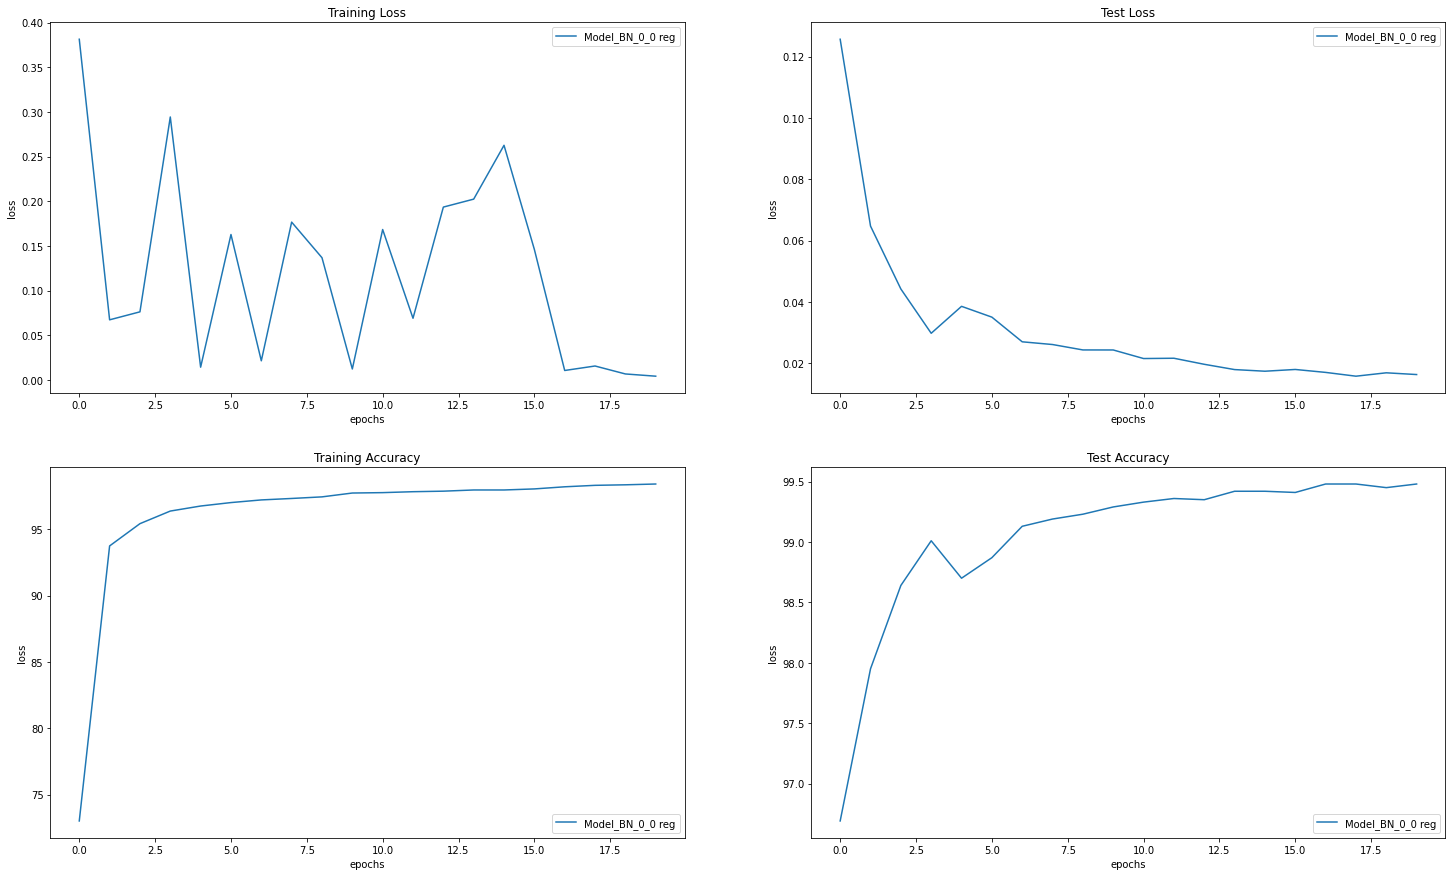

In [ ]:
plot_metrics('Model_BN_0_0.csv', 'Model_BN_0_0')

### Plot for Batch Normalization with L1 factor as 0 and L2 factor as 0.001

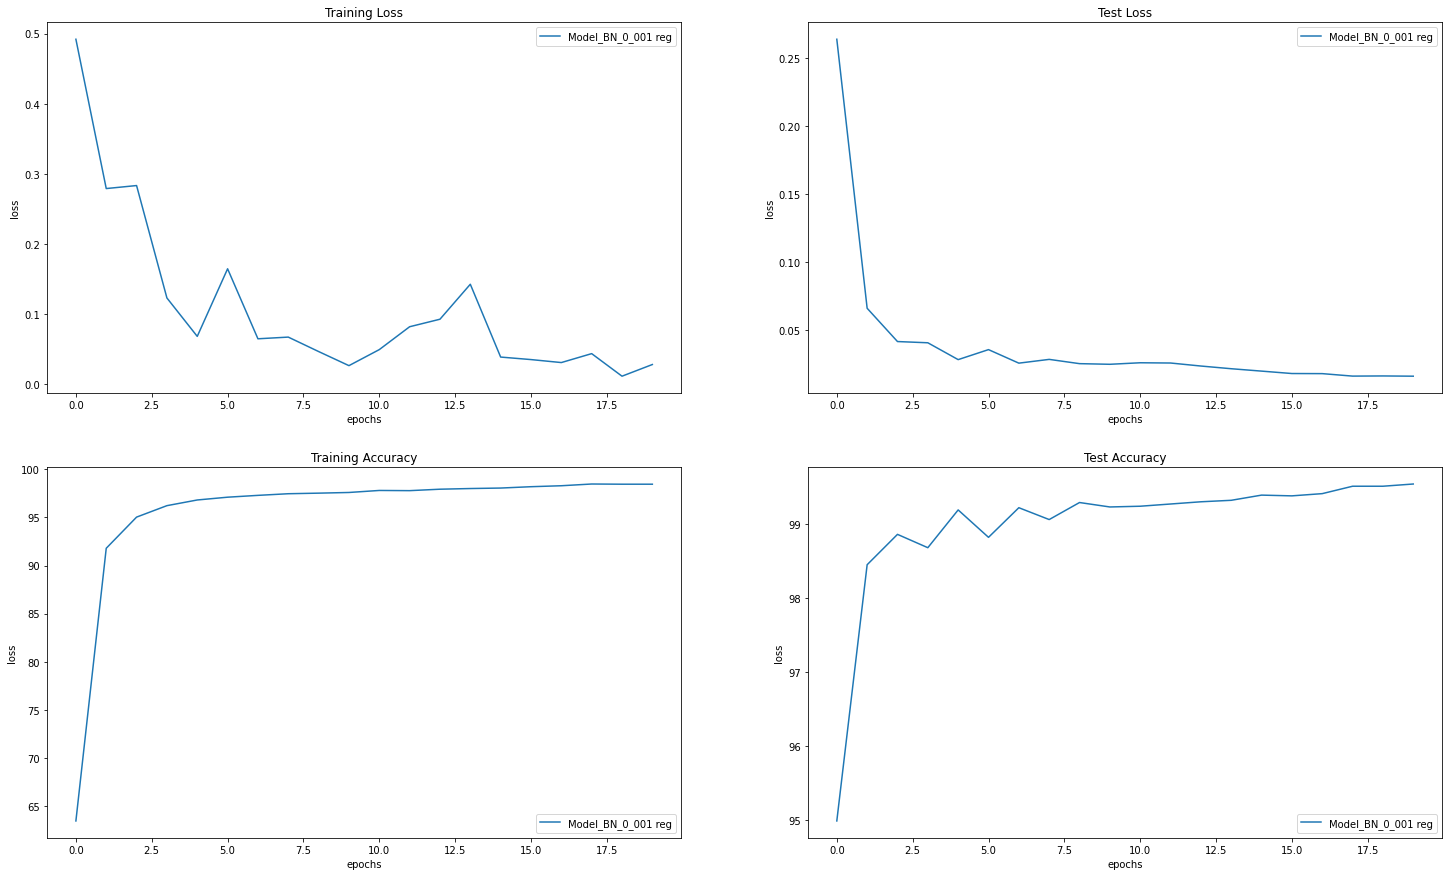

In [ ]:
plot_metrics('Model_BN_0_001.csv', 'Model_BN_0_001')

### Plot for Batch Normalization with L1 factor as 0 and L2 factor as 0.002

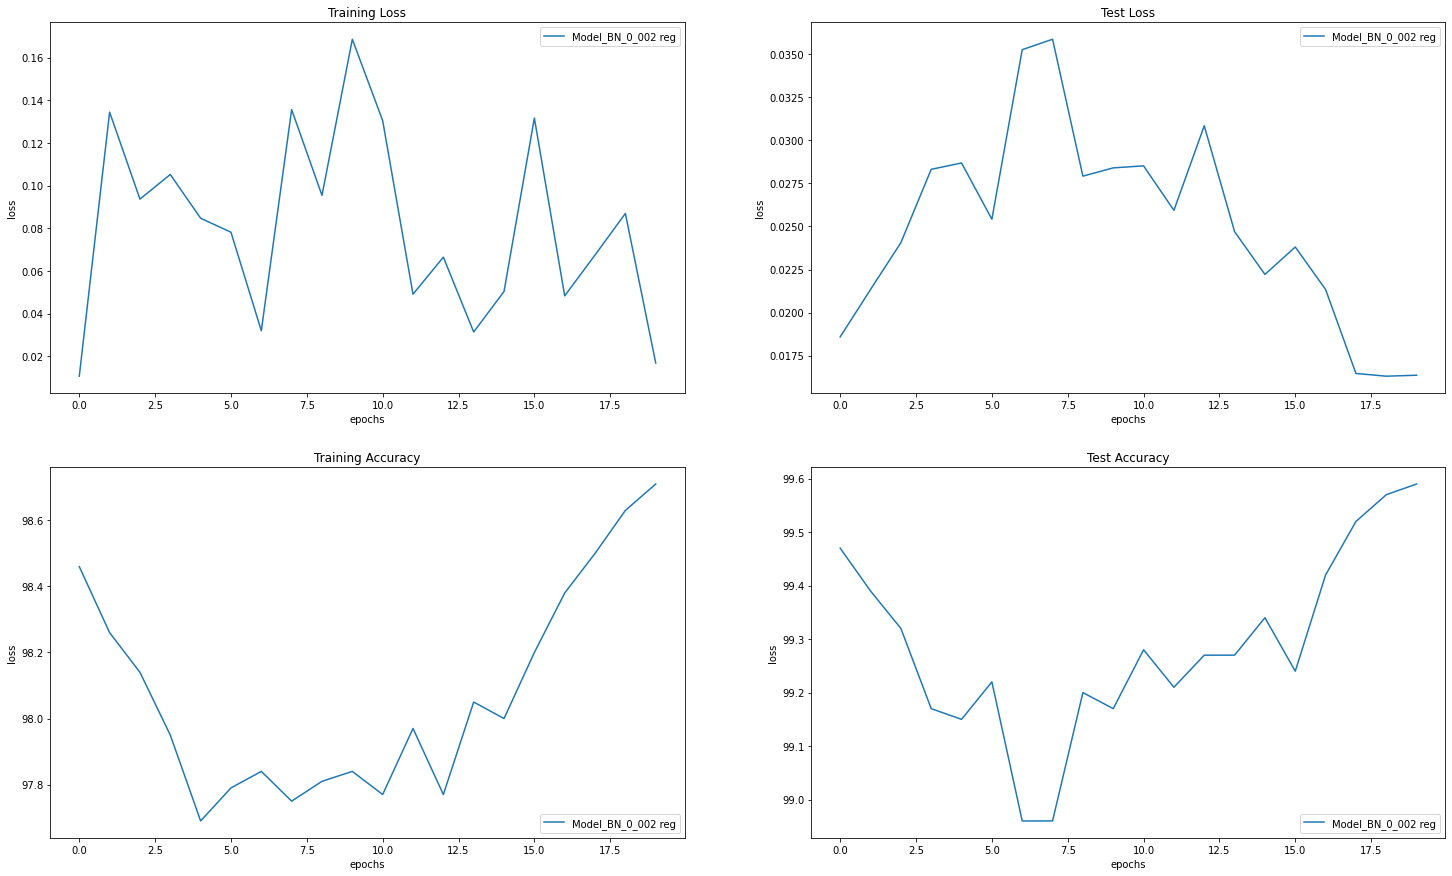

In [ ]:
plot_metrics('Model_BN_0_002.csv', 'Model_BN_0_002')

###Plot for Batch Normalization with L1 factor as 0.001 and L2 factor as 0

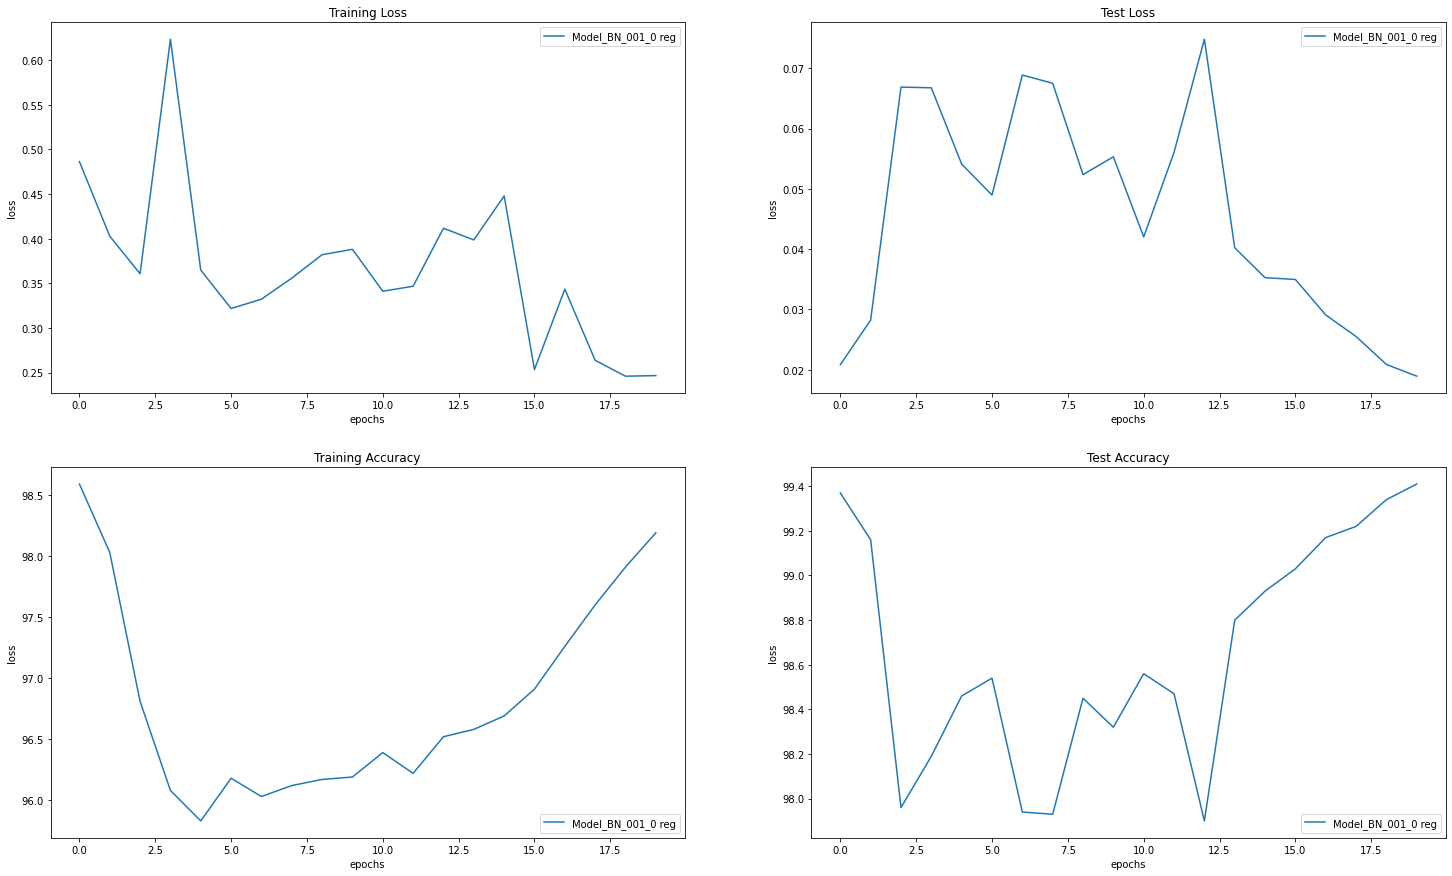

In [ ]:
plot_metrics('Model_BN_001_0.csv', 'Model_BN_001_0')

###Plot for Batch Normalization with L1 factor as 0.001 and L2 factor as 0.001

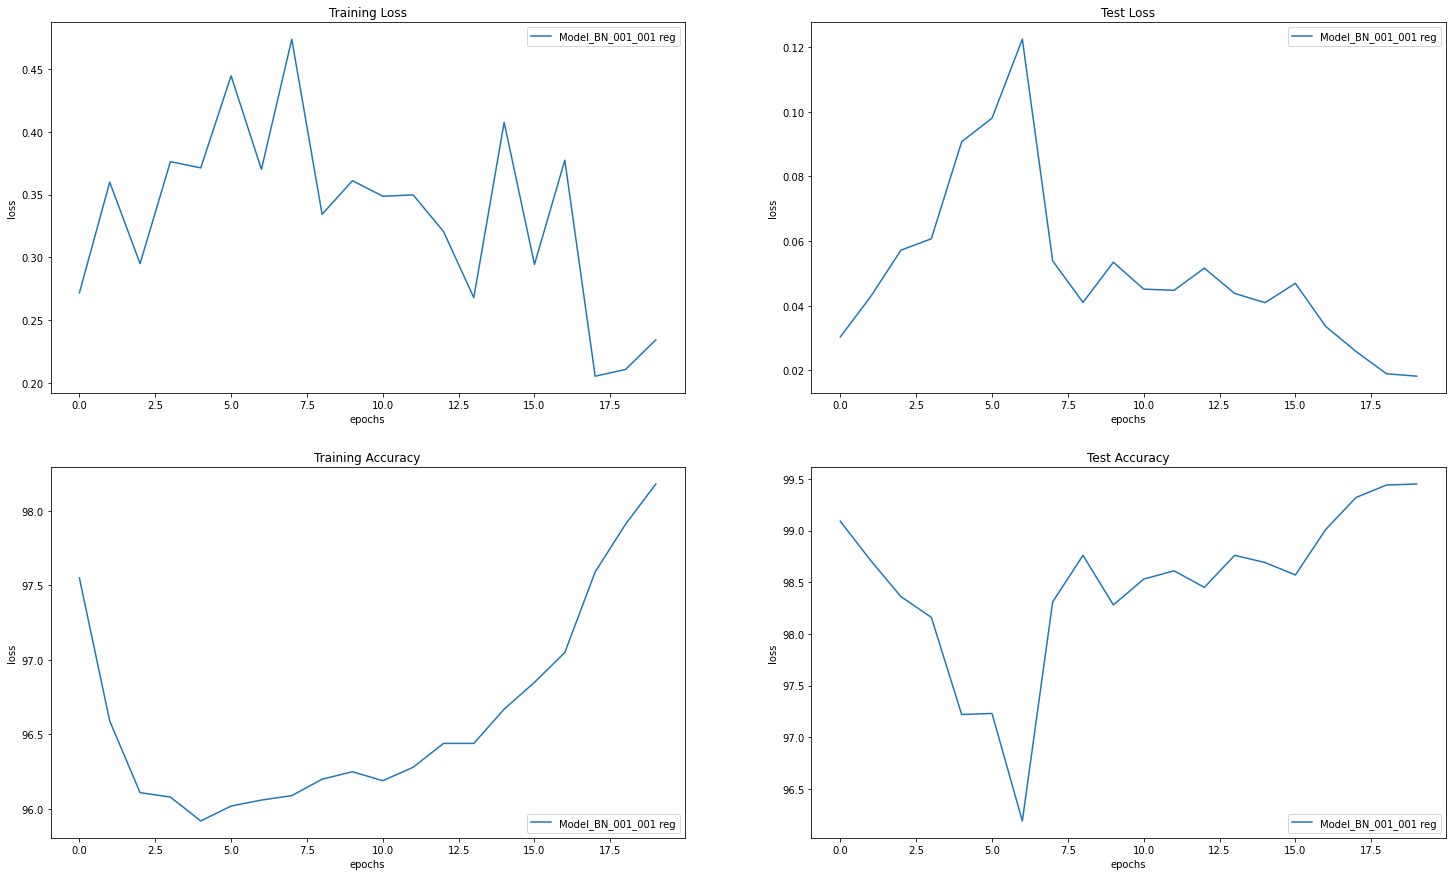

In [ ]:
plot_metrics('Model_BN_001_001.csv', 'Model_BN_001_001')

###Plot for Batch Normalization with L1 factor as 0.001 and L2 factor as 0.002

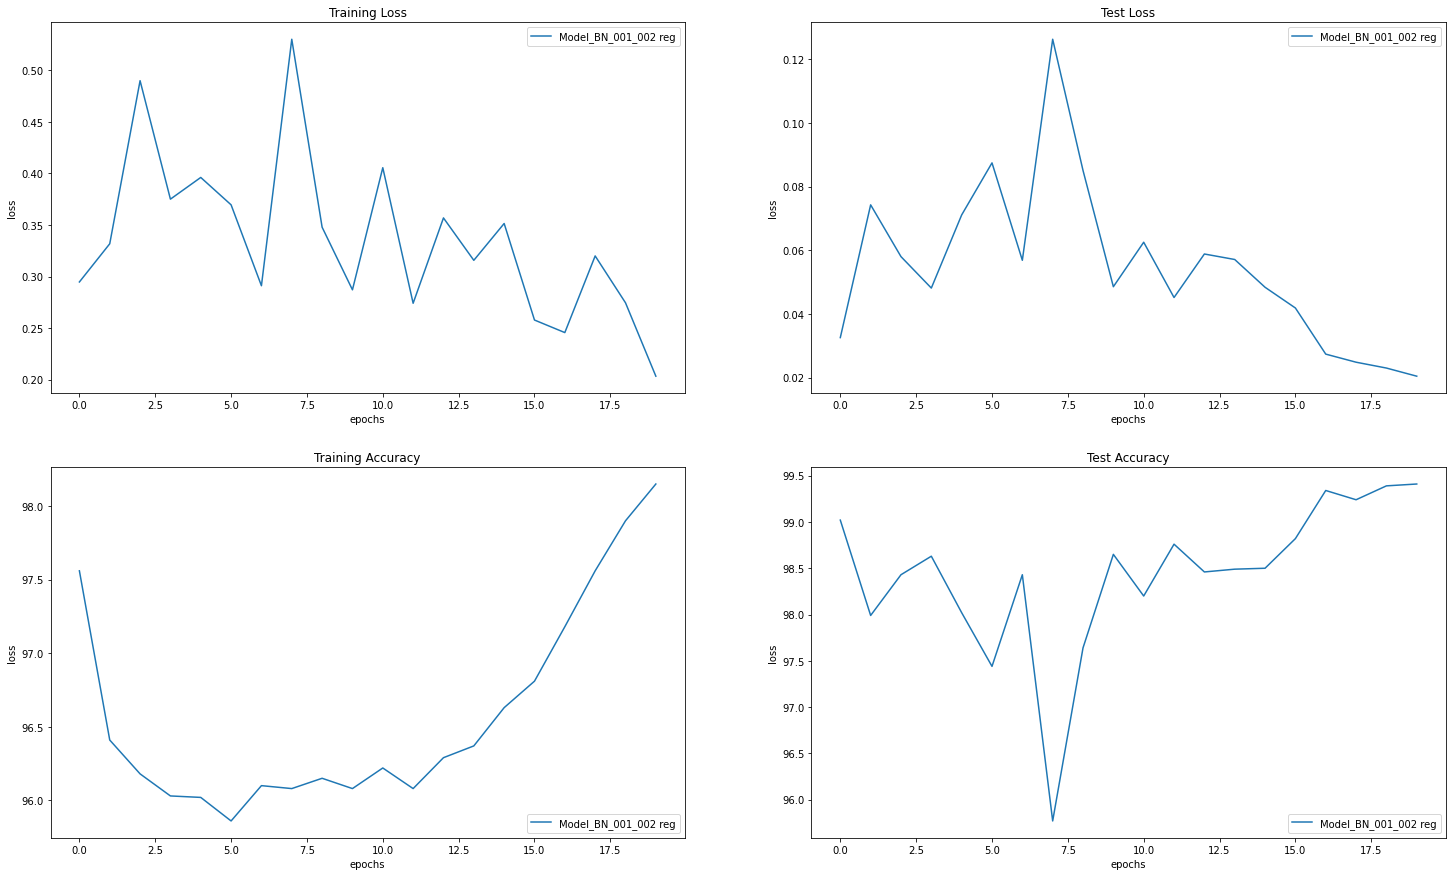

In [ ]:
plot_metrics('Model_BN_001_002.csv', 'Model_BN_001_002')

###Plot for Batch Normalization with L1 factor as 0.002 and L2 factor as 0

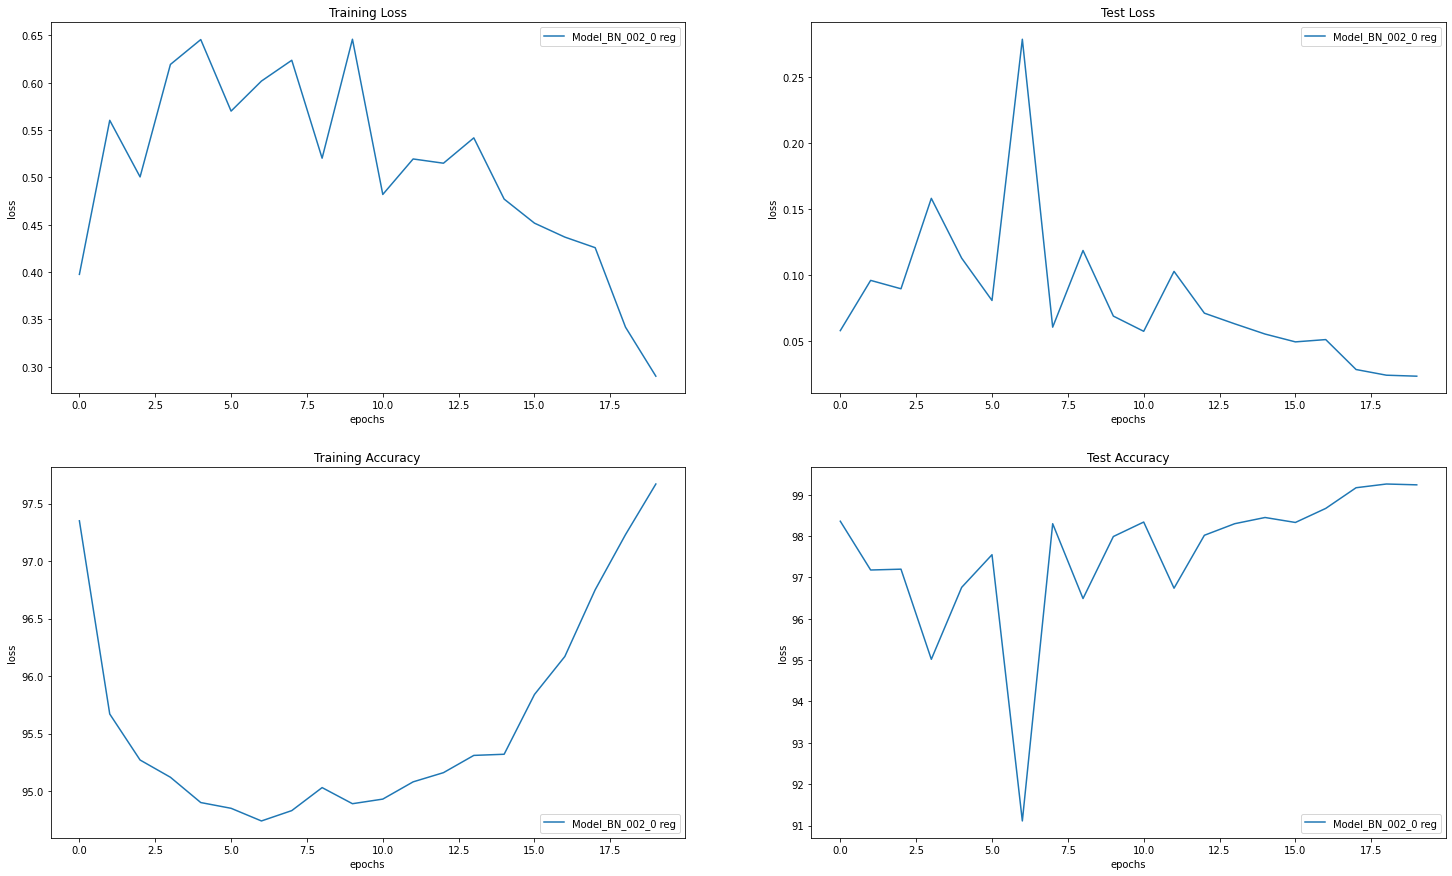

In [ ]:
plot_metrics('Model_BN_002_0.csv', 'Model_BN_002_0')

###Plot for Batch Normalization with L1 factor as 0.002 and L2 factor as 0.001

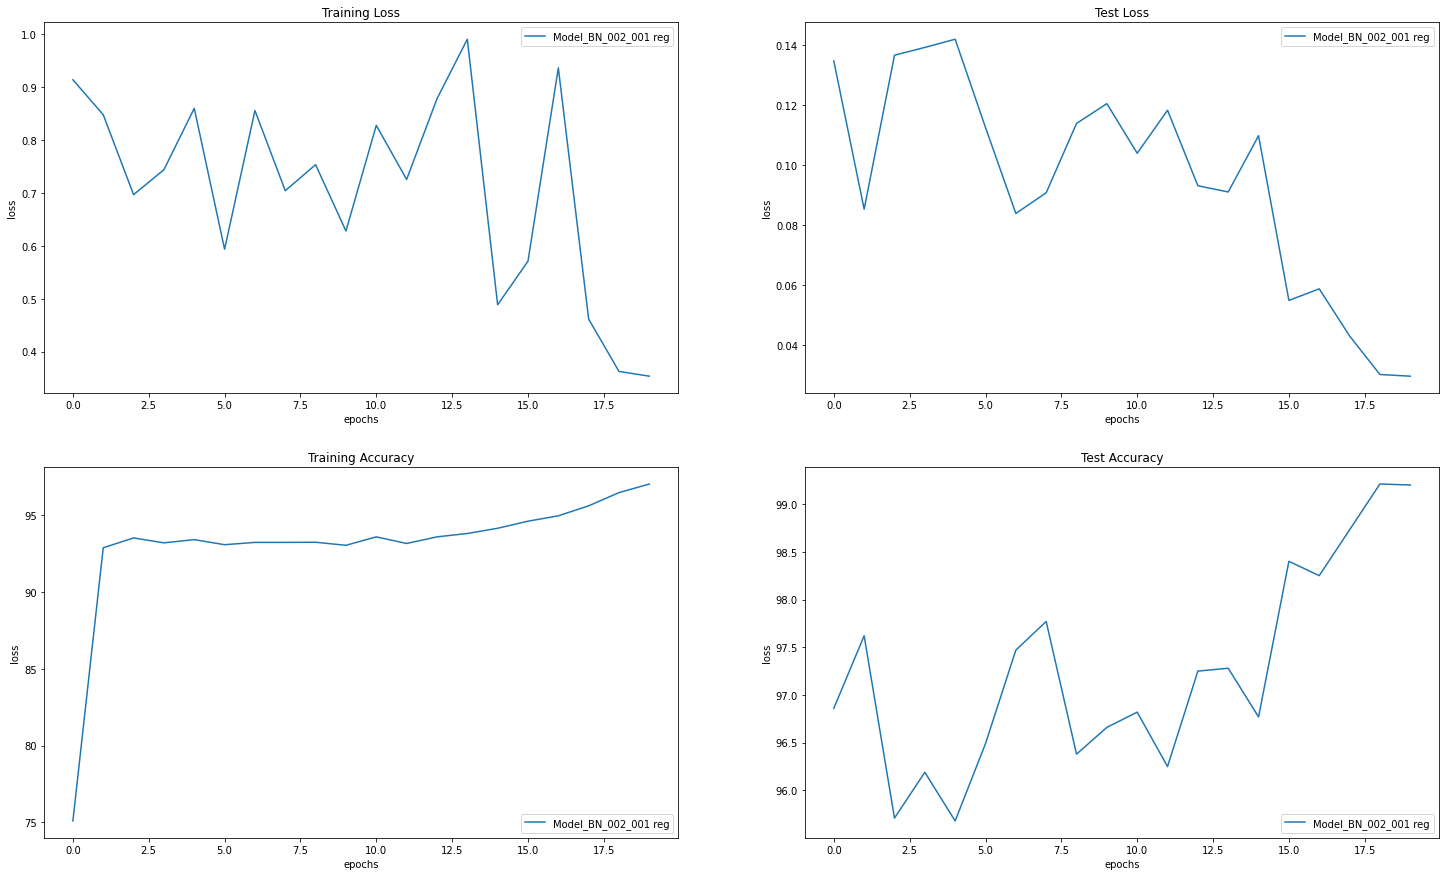

In [ ]:
plot_metrics('Model_BN_002_001.csv', 'Model_BN_002_001')

###Plot for Batch Normalization with L1 factor as 0.002 and L2 factor as 0.002

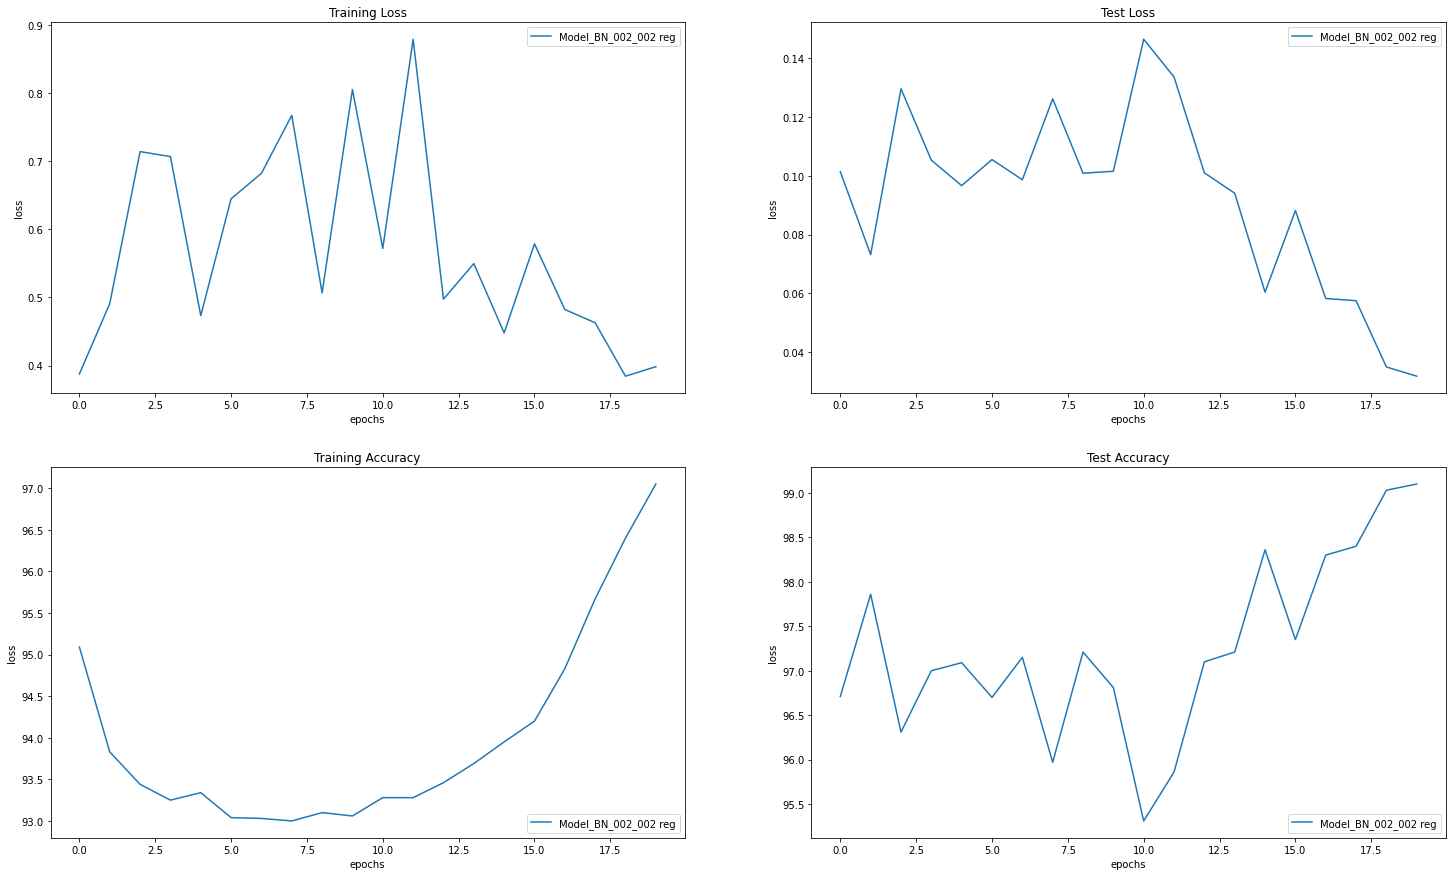

In [ ]:
plot_metrics('Model_BN_002_002.csv', 'Model_BN_002_002')

###Plot for Layer Normalization with L1 factor as 0 and L2 factor as 0

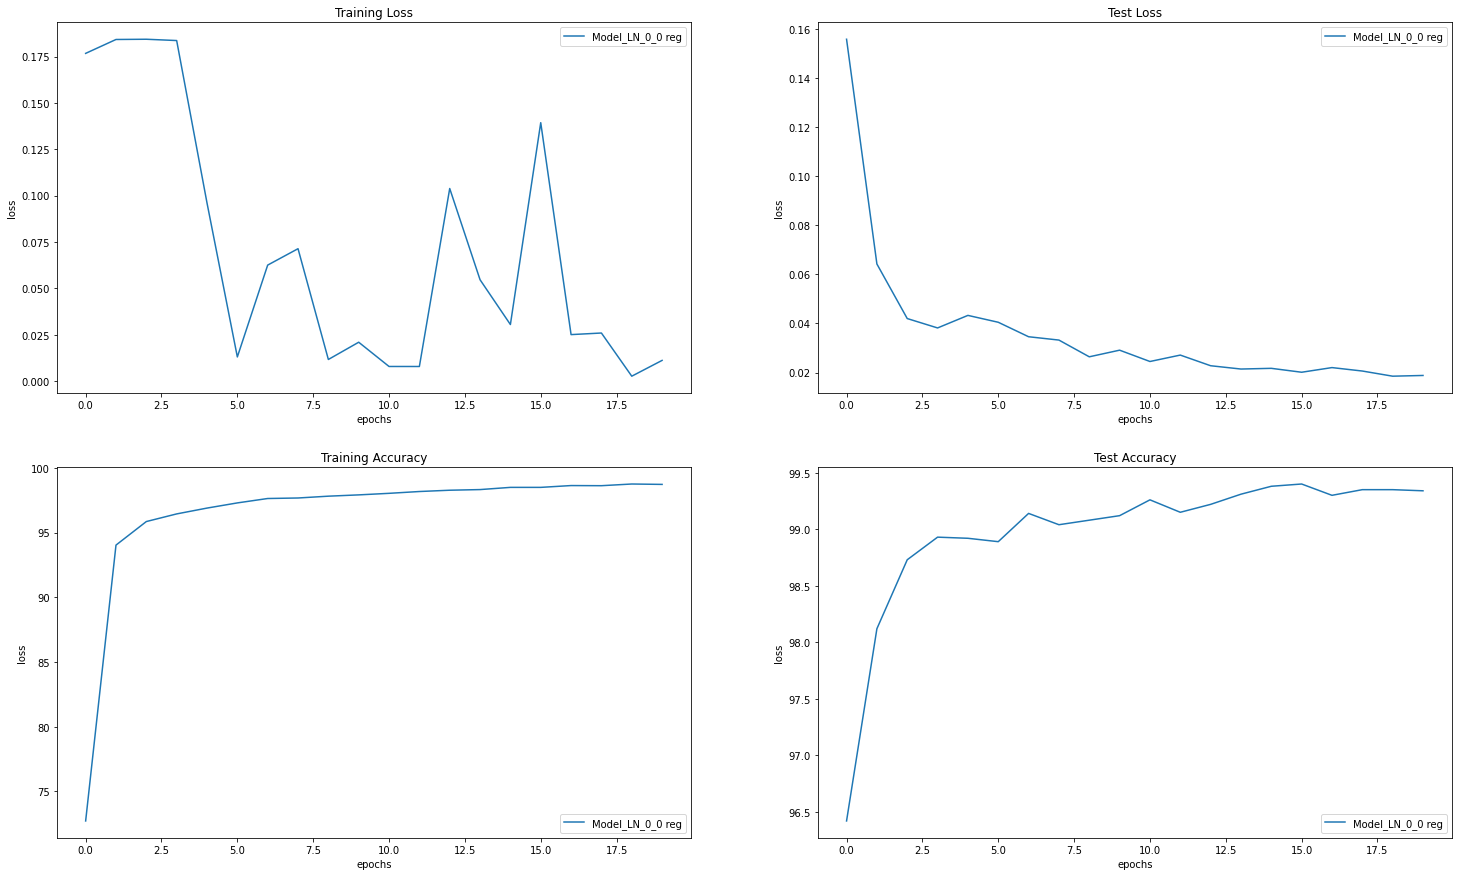

In [ ]:
plot_metrics('Model_LN_0_0.csv', 'Model_LN_0_0')

###Plot for Layer Normalization with L1 factor as 0 and L2 factor as 0.001

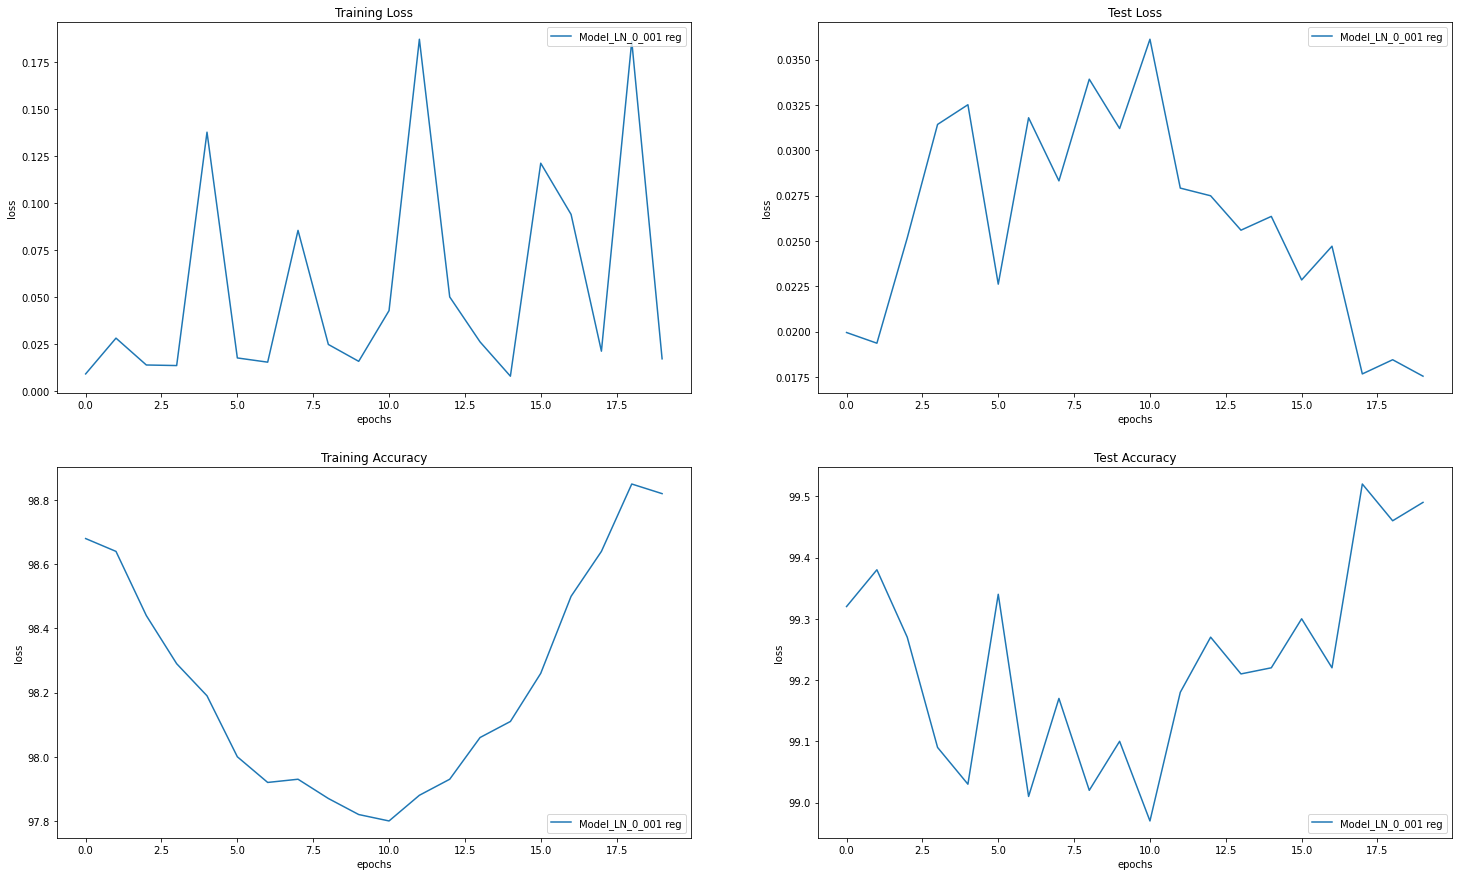

In [ ]:
plot_metrics('Model_LN_0_001.csv', 'Model_LN_0_001')

####Plot for Layer Normalization with L1 factor as 0 and L2 factor as 0.002

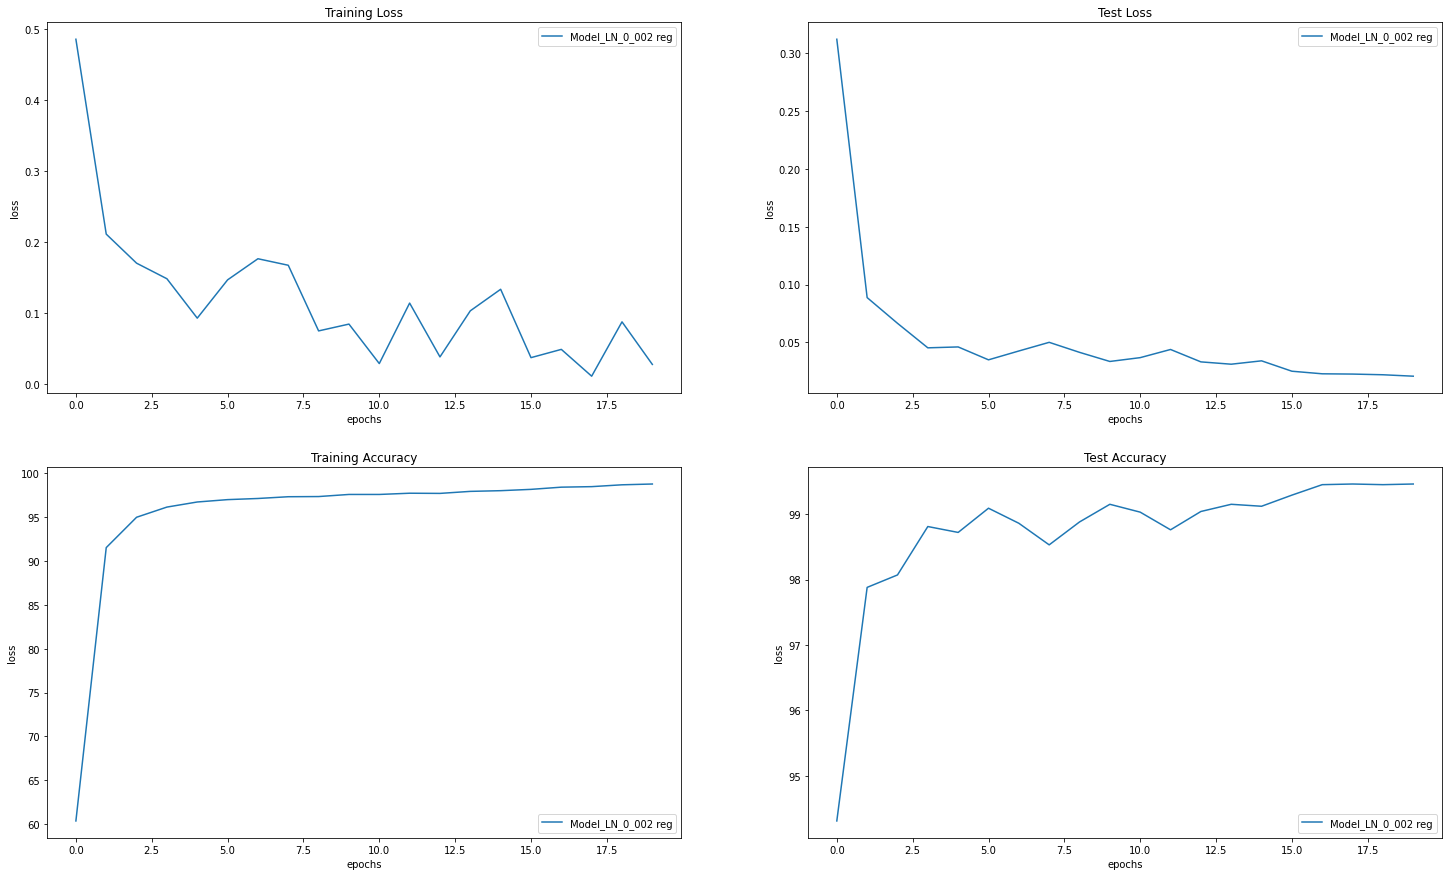

In [ ]:
plot_metrics('Model_LN_0_002.csv', 'Model_LN_0_002')

###Plot for Group Normalization with L1 factor as 0 and L2 factor as 0

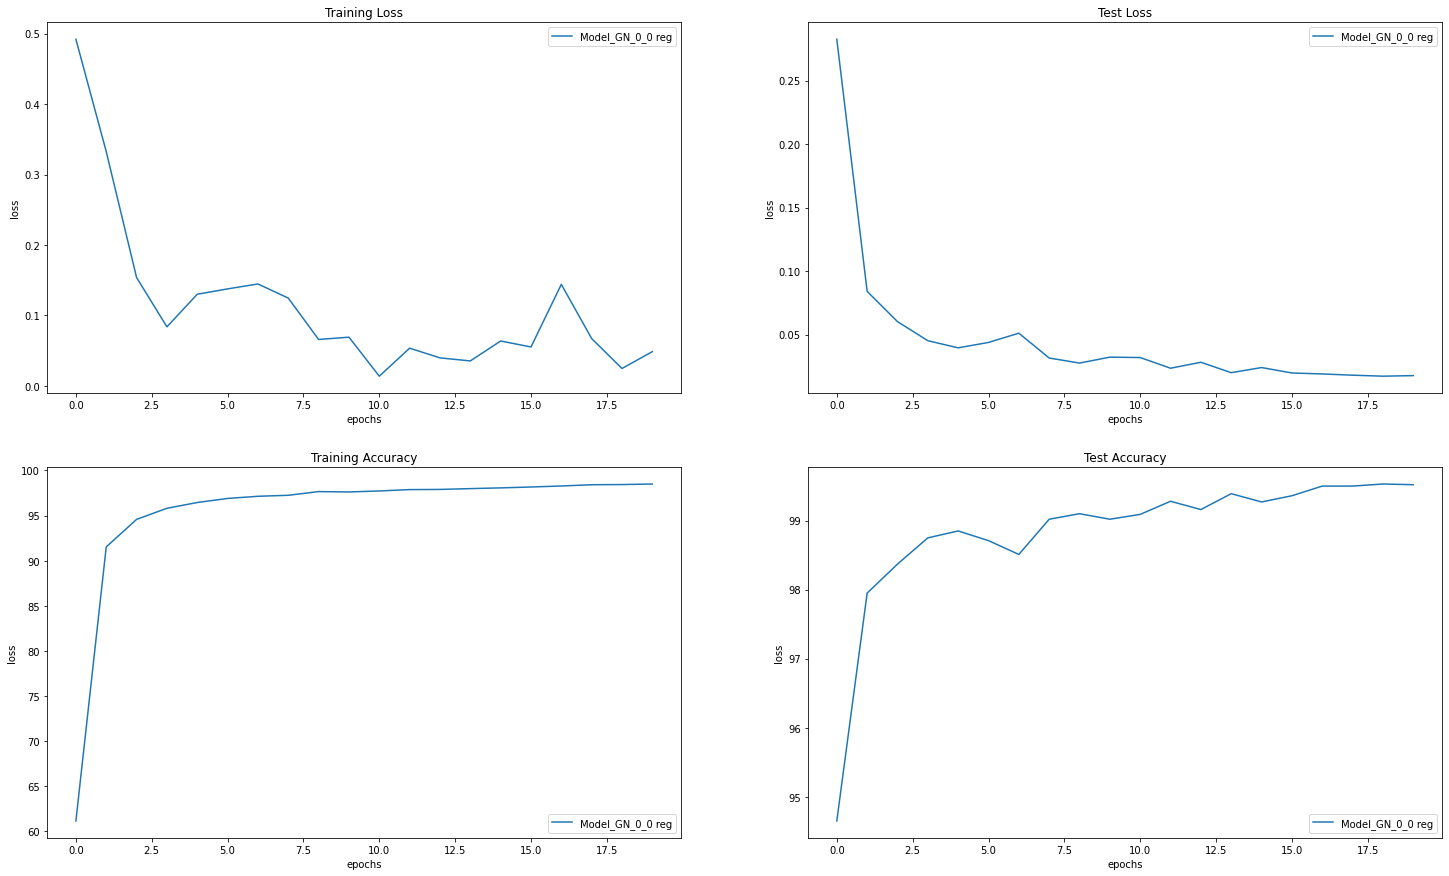

In [ ]:
plot_metrics('Model_GN_0_0.csv', 'Model_GN_0_0')

###Plot for Group Normalization with L1 factor as 0 and L2 factor as 0.001

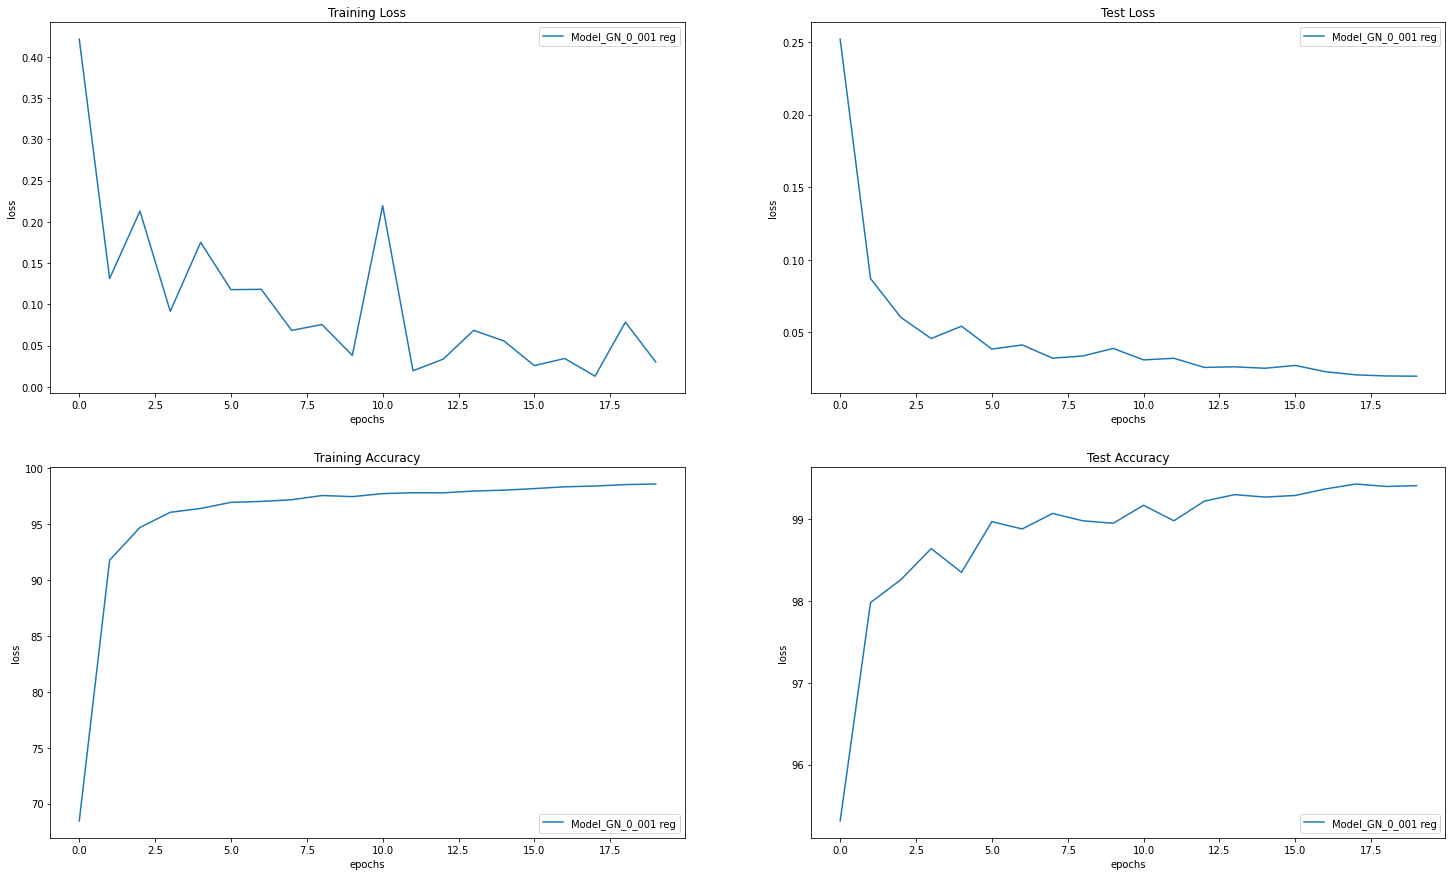

In [ ]:
plot_metrics('Model_GN_0_001.csv', 'Model_GN_0_001')

###Plot for Group Normalization with L1 factor as 0 and L2 factor as 0.002

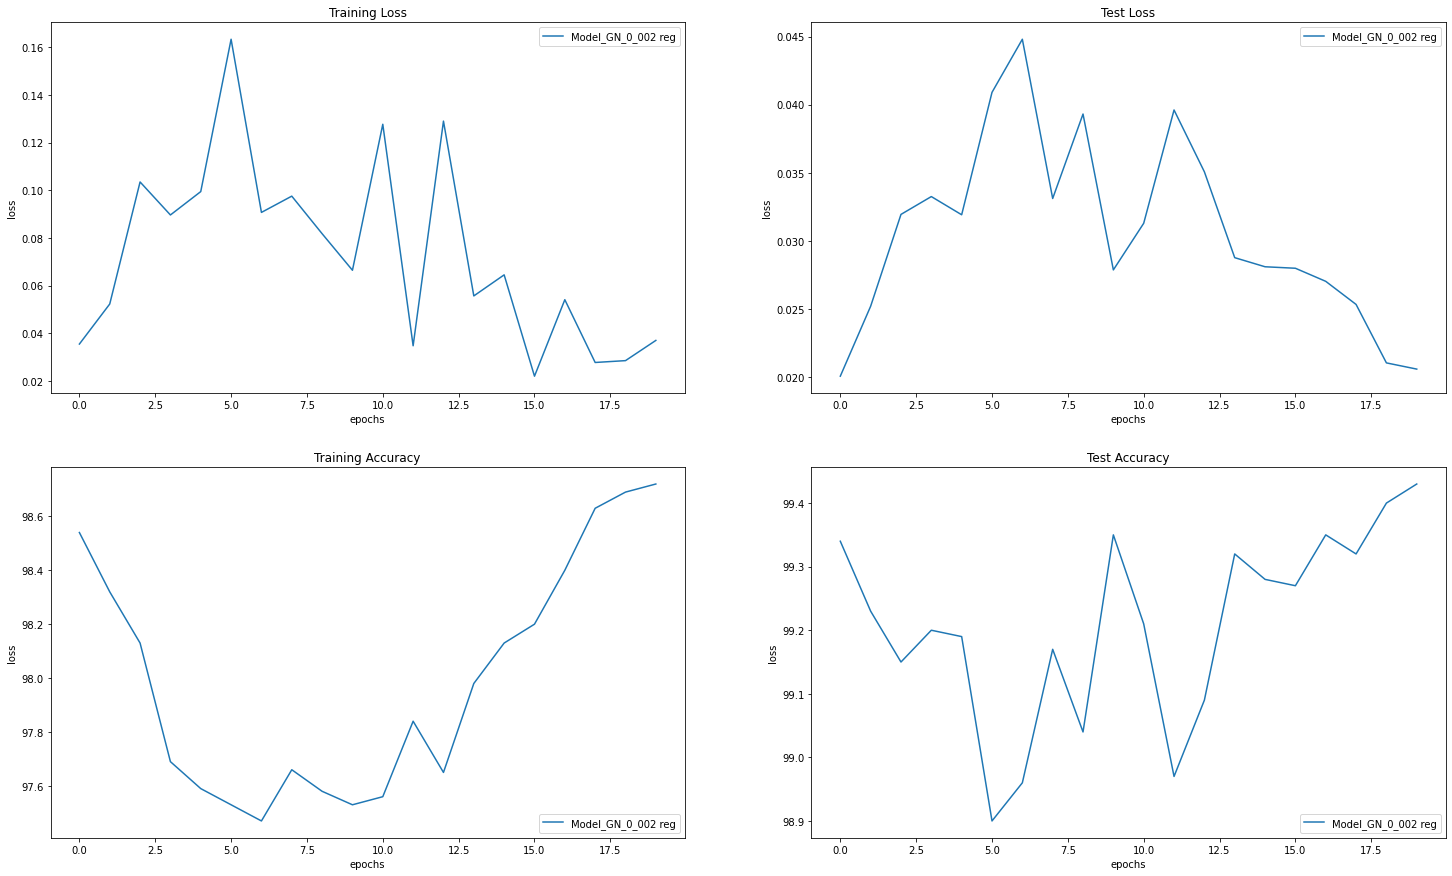

In [ ]:
plot_metrics('Model_GN_0_002.csv', 'Model_GN_0_002')

#Comparison Chart for various Batch Normalization Models

###Batch Normalization Comparison Chart

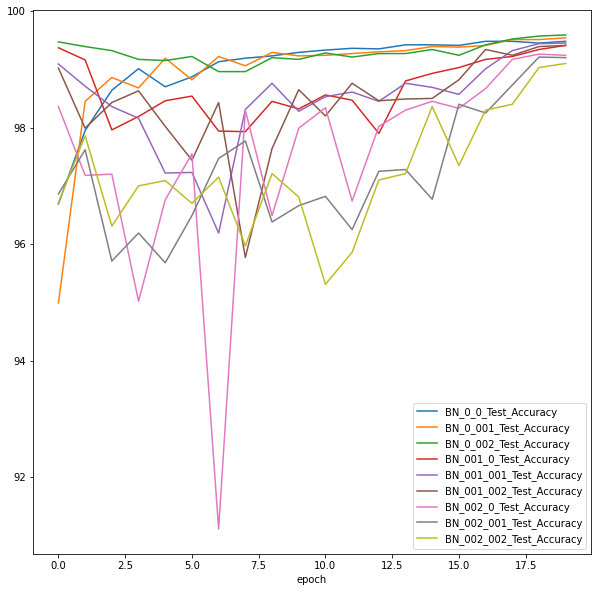

In [ ]:
import pandas as pd
df_bn_combined = pd.read_csv('BN_Combined.csv')
df_bn_combined.plot(x="epoch", y=["BN_0_0_Test_Accuracy", "BN_0_001_Test_Accuracy",
                                  "BN_0_002_Test_Accuracy", "BN_001_0_Test_Accuracy",
                                  "BN_001_001_Test_Accuracy", "BN_001_002_Test_Accuracy",
                                  "BN_002_0_Test_Accuracy", "BN_002_001_Test_Accuracy",
                                  "BN_002_002_Test_Accuracy"],
        kind="line", figsize=(10, 10));

Looks like the first three, that is, batch normalization with l1 factor as 0 and l2 factors as 0, .001 and .002 have best of the test accuracies. L1 is too harsh in shrinking the coefficients of the features while compared to L2. Now we would conduct similar studies for other normalizations.

###Layer Normalization Comparison Chart

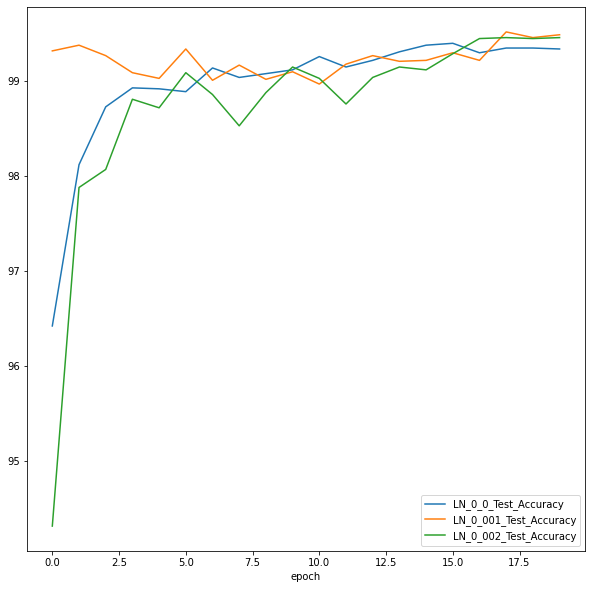

In [ ]:
df_ln_combined = pd.read_csv('LN_Combined.csv')
df_ln_combined.plot(x="epoch", y=["LN_0_0_Test_Accuracy", "LN_0_001_Test_Accuracy",
                                  "LN_0_002_Test_Accuracy"],
        kind="line", figsize=(10, 10));

More or less LN accuracies are comparable. For L2 factor (decay rate) as .001, test accuracy decreased than initial, rather for L1 factor as 0, and L2 factor as 0, the increase in test accuracy seems better (steady graph) as and when the model learns the general trends better.

###Group Normalization Comparison Chart

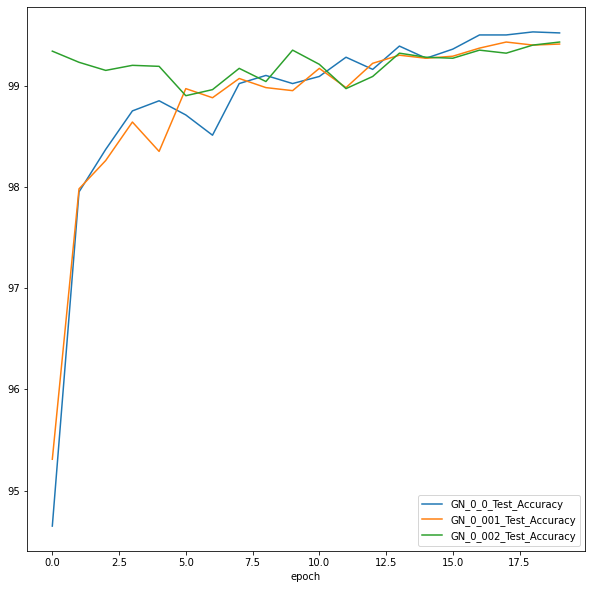

In [ ]:
df_gn_combined = pd.read_csv('GN_Combined.csv')
df_gn_combined.plot(x="epoch", y=["GN_0_0_Test_Accuracy", "GN_0_001_Test_Accuracy",
                                  "GN_0_002_Test_Accuracy"],
        kind="line", figsize=(10, 10));

In the similar line as we discussed earlier, group normalization with L1 factor as 0 and L2 factor as 0 shows more steady increase graph and after epoch 15, it has the best accuracy.

###Combined study of three normalizations

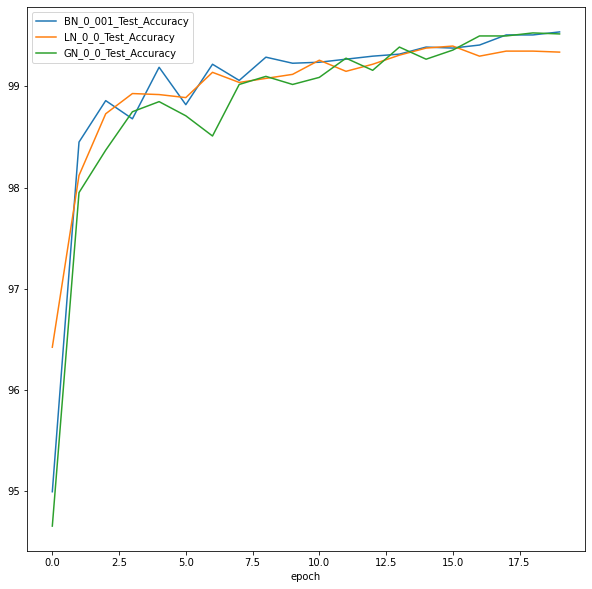

In [ ]:
df_all_combined = pd.read_csv('All_Combined.csv')
df_all_combined.plot(x="epoch", y=["BN_0_001_Test_Accuracy", "LN_0_0_Test_Accuracy",
                                  "GN_0_0_Test_Accuracy"],
        kind="line", figsize=(10, 10));

So, we see, after approximate 17 epochs, both batch and group normalizations reached the best test accuracy while layer normalization fall apart starting from epochs around 17. But its needless to say, all three have reached to a quite good accuracy may be because of less complex MNIST data set. For more complex image related problems (for example imagenet case), batch normalization should do a lot better than the corresponding layer normalization counterpart.

###Test Loss graph for three best models

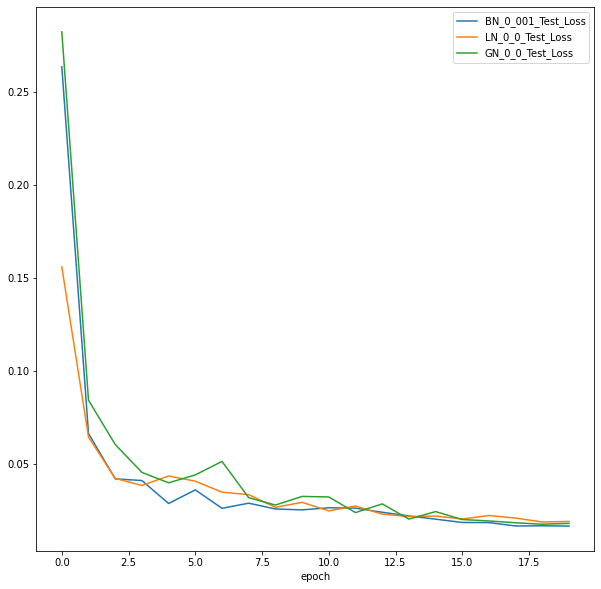

In [10]:
import pandas as pd
df_all_combined = pd.read_csv('All_Combined_Validation_Loss.csv')
df_all_combined.plot(x="epoch", y=["BN_0_001_Test_Loss", "LN_0_0_Test_Loss",
                                  "GN_0_0_Test_Loss"],
        kind="line", figsize=(10, 10));

#Displaying mispredictions for best three models using three different normalization types

In [ ]:
import pickle
import matplotlib.pyplot as plt
import torch
%matplotlib inline

def show_mispredictions(model_dict_pickle_file, model_key):
  '''
  This method loads the mispredictions dictionary per model wise
  and plots results

  :param model_dict_pickle_file: pickle file name
  :param model_key: model_key
  '''
  with open(model_dict_pickle_file, 'rb') as handle:
    wrong_predictions = pickle.load(handle)

    try:
      fig = plt.figure(figsize=(8,10))
      fig.tight_layout()
      for i in range(len(wrong_predictions[model_key])):
        img, pred, target = wrong_predictions[model_key][i][0][0], wrong_predictions[model_key][i][0][1], wrong_predictions[model_key][i][0][2] 
        ax = fig.add_subplot(5, 2, i+1)
        ax.axis('off')
        ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
        ax.imshow(img.squeeze(), cmap='gray_r') 
    except:
      pass
  return

### Mispredictions for best Layer Normalization Model

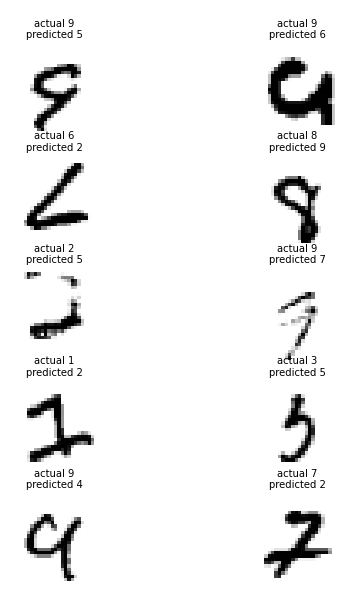

In [ ]:
show_mispredictions('Model_LN_0_0.pkl', 'Model_LN_0_0')

###Mispredictions for best Batch Normalization Model

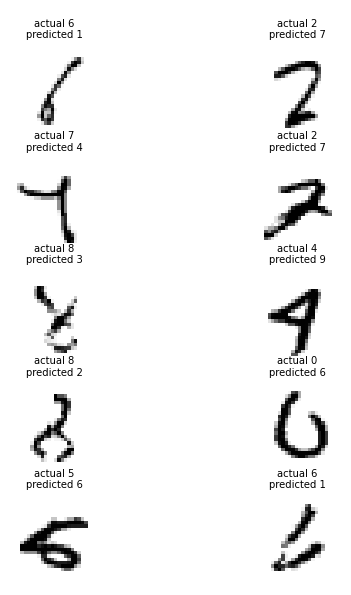

In [ ]:
show_mispredictions('Model_BN_0_001.pkl', 'Model_BN_0_001')

###Mispredictions for best Group Normalization Model

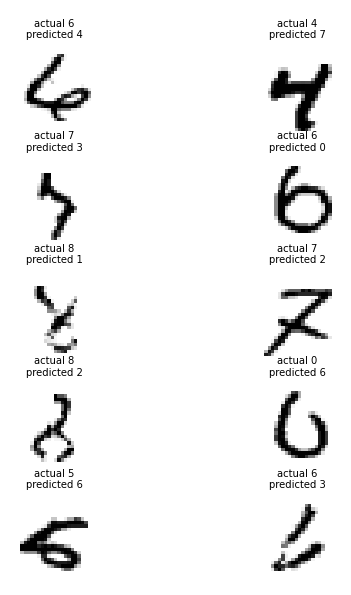

In [ ]:
show_mispredictions('Model_GN_0_0.pkl', 'Model_GN_0_0')